In [1]:
%pip install brokenaxes==0.2
%pip install fpdf
# %pip install spacy
# !python -m spacy download zh_core_web_sm
%pip install numpy==1.26.4
%pip install pandas
# %pip install sklearn

  Using cached brokenaxes-0.2-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached brokenaxes-0.2-py2.py3-none-any.whl (6.5 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached fpdf-1.7.2-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 whic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import seaborn as sns
import geopandas as gpd
# import spacy

import re
from brokenaxes import brokenaxes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import mstats

import os
import zipfile
import shutil
from fpdf import FPDF

In [3]:
# Import fonts support Chinese characters
plt.rcParams['font.sans-serif'] = ['AR PL KaitiM GB']
plt.rcParams['axes.unicode_minus'] = False    # Ensure minus signs are displayed correctly

In [4]:
hr_df = pd.read_csv('WTL Analyst Data - 20X2Q3工时数据.csv')
gs = pd.read_csv('WTL Analyst Data - GS项目.csv')
iss = pd.read_csv('WTL Analyst Data - ISS项目.csv')

In [5]:
hr_df.head()

日期                                         项目   阶段   部门  \
0  07/29-08/04       GS220026-SD03 歌尔光电园二期综合服务楼二标段室内精装修项目  NaN  IT部   
1  07/29-08/04  GS220067-SD09 嘉行传媒-BJ-朝阳751园A21栋办公室设计施工项目  NaN  IT部   
2  07/29-08/04                GS220080-BJ11 温哥华森林别墅设计施工项目  NaN  IT部   
3  07/29-08/04      GS230020-SD03 歌尔科技产业项目二期内装及机电安装深化设计项目  NaN  IT部   
4  07/29-08/04                  GS230067-BJ09 金尚城溪-设计施工项目  NaN  IT部   

                           具体任务    工时  
0     郑志强咨询音轨重合分离相关问题。帮忙寻求专业人员。   1.0  
1            报修拼接屏故障，沟通甲方及厂商。报价   1.0  
2         温哥华KTV房音视频方案，发预算开始报价。   1.0  
3             根据图审C栋意见，调整E栋施工图。  30.0  
4  方案调整，参加方案交底会，沟通运营商现场踏勘，调整图纸。  15.0

Observation of work hours data: 日期 is a time range, probably need separation to start date and end date. 项目 and 具体任务 columns include project_id, for example GS220026-SD03. This need auto identifier to extract the IDs and create a new column, for further data merging.

By simple sorting and looking up, there are many projects for example GS220080-BJ11 温哥华森林别墅设计施工项目, and GS22, GS23xxx projects cannot be found in GS Projects data.

- Thus consider outer join datasets
- and further investigate the project description to see if there are any similar projects may be matched.

In [6]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      2168 non-null   object 
 1   项目      2168 non-null   object 
 2   阶段      680 non-null    object 
 3   部门      2168 non-null   object 
 4   具体任务    2079 non-null   object 
 5   工时      2167 non-null   float64
dtypes: float64(1), object(5)
memory usage: 101.8+ KB


In [7]:
nan_hr = hr_df[hr_df[['工时']].isna().any(axis=1)]

# Display the result
nan_hr

日期                                     项目   阶段   部门  \
223  08/05-08/11  GS240013-SH01 上海联江芯亚芯科技园2号楼7楼局部装修施工项目  NaN  IT部   

                                  具体任务  工时  
223  TP-Link项目、上海歌尔两次改造，辅助劳务和预算进行对量工作。 NaN

2 options to deal with work hour nan: fill in with 0, or mean/median of same/similar project

Fill in 0 will probably cause us miss valuable information, plus it is not common to see an nan, we can contact the person to understand the story, but before doing that, we can do some guess, by interpolation using median of the same project.

By first, we need to clean data, and split 项目 into 项目编码 and 项目描述

In [8]:
hr_df[['项目编码', '项目名称']] = hr_df['项目'].str.extract(r'(^\S+)\s+(.+)')
hr_df['项目名称'].fillna(hr_df['项目'], inplace=True)

Now we need to fill in missing 编码 描述 based on each other

In [9]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      2168 non-null   object 
 1   项目      2168 non-null   object 
 2   阶段      680 non-null    object 
 3   部门      2168 non-null   object 
 4   具体任务    2079 non-null   object 
 5   工时      2167 non-null   float64
 6   项目编码    1744 non-null   object 
 7   项目名称    2168 non-null   object 
dtypes: float64(1), object(7)
memory usage: 135.6+ KB


In [10]:
# First condition: based on 项目编码
cond1 = hr_df['项目编码'] == 'GS240013-SH01'

# Second condition: based on 项目描述
cond2 = hr_df['项目名称'] == '上海联江芯亚芯科技园2号楼7楼局部装修施工项目'

# Combine the two conditions using OR
combined_condition = cond1 | cond2

# Filter the DataFrame based on the combined condition, AND EXCLUDE NAN
filtered_df = hr_df[combined_condition & hr_df['工时'].notna()]

# Calculate the median of '工时' for the filtered rows
median_hr = filtered_df['工时'].median()
median_hr

1.0

Now we fill in 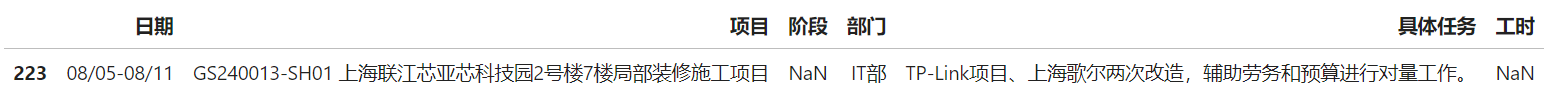 nan as 1.0 hour

In [11]:
hr_df.loc[223, '工时'] = median_hr

Now we can visualize work hours by department

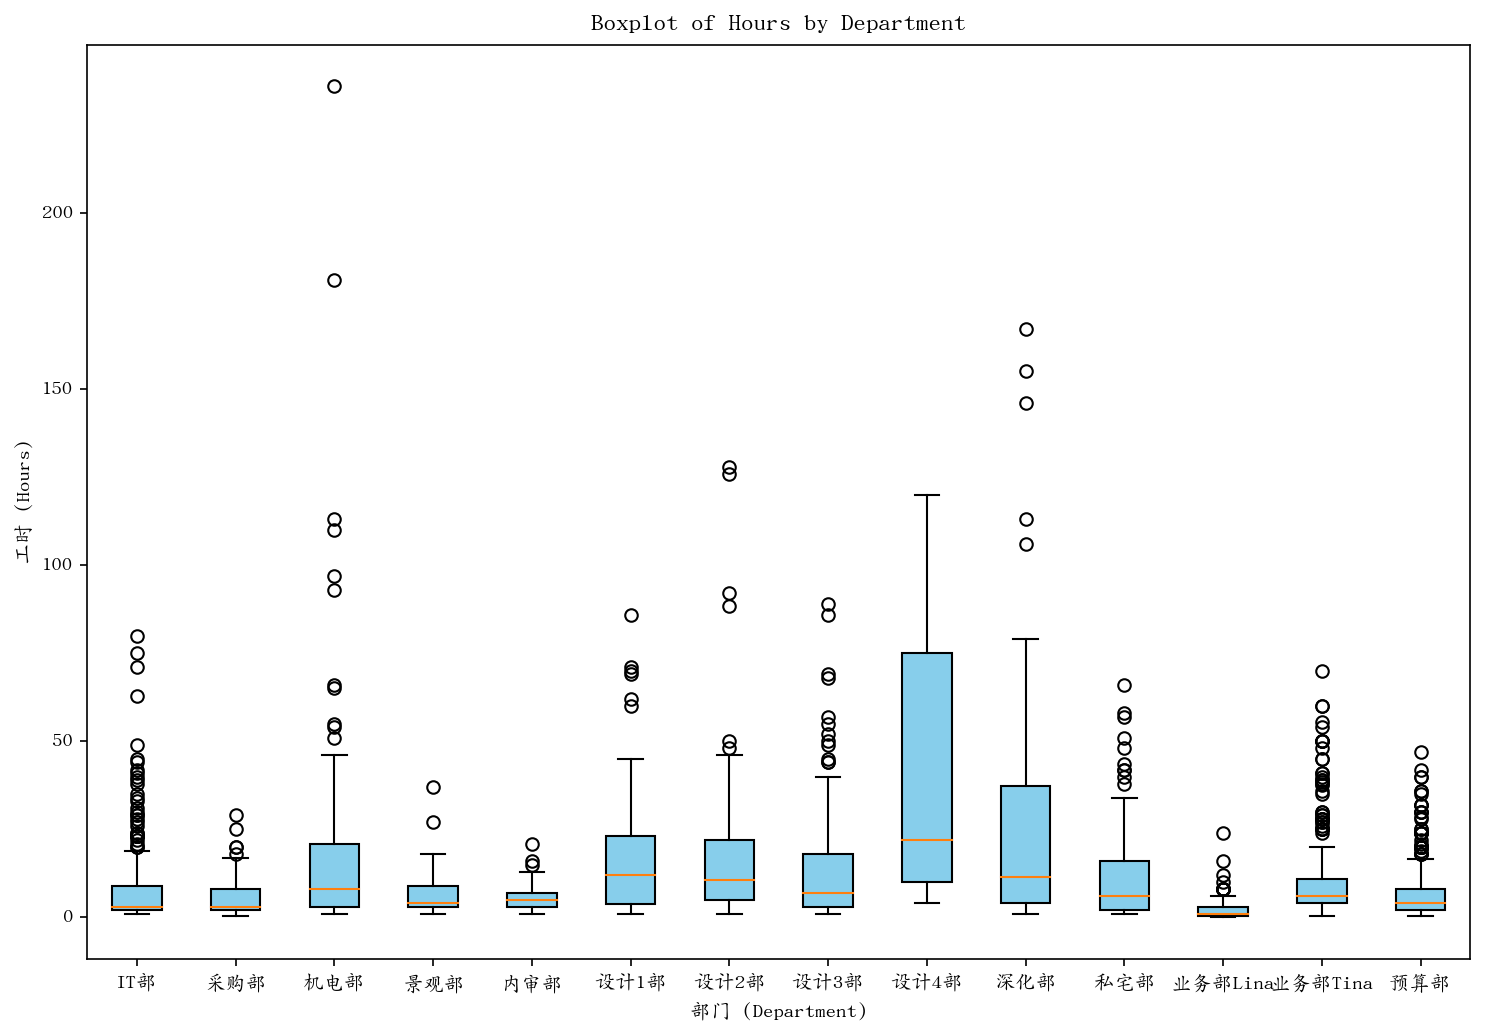

In [12]:
hr_dp = hr_df[['部门', '工时']]
data_grouped = [hr_dp[hr_dp['部门'] == dept]['工时'].values for dept in hr_dp['部门'].unique()]

plt.figure(figsize=(10, 7), dpi=150)  # Set a higher DPI value to increase resolution
plt.boxplot(data_grouped, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.xticks(range(1, len(hr_dp['部门'].unique()) + 1), hr_dp['部门'].unique())
plt.xlabel('部门 (Department)')
plt.ylabel('工时 (Hours)')
plt.title('Boxplot of Hours by Department')
plt.tight_layout()
plt.savefig('Boxplot of Hours by Department.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

There are quite obvious outliers for example 机电部, but consider this is an aggregated one, it may make sense. To figure out if it make sense, I am using below method:

In [13]:
grouped_df = hr_df.groupby(['项目', '部门'])['工时'].agg(['mean', 'median', 'std', 'count']).reset_index()
grouped_df = grouped_df[grouped_df['count'] != 0]
grouped_df = grouped_df.rename(columns={"mean": "mean_hr", 'median': 'benchmark_hr', "std": "std_hr", 'count': 'amount'})
hr_df = pd.merge(hr_df, grouped_df, on=['项目', '部门'], how='left')

# Define thresholds for outliers (mean ± 2*std)
hr_df['upper_bound'] = hr_df['mean_hr'] + 2 * hr_df['std_hr']
hr_df['lower_bound'] = hr_df['mean_hr'] - 2 * hr_df['std_hr']

outliers_df = hr_df[(hr_df['工时'] > hr_df['upper_bound']) | (hr_df['工时'] < hr_df['lower_bound'])]

# Select relevant columns to display outliers
outliers_df = outliers_df[['日期', '项目', '部门', '具体任务', '工时', 'mean_hr', 'std_hr', 'upper_bound', 'lower_bound', 'amount']]
outliers_df = outliers_df.rename(columns={'amount': 'Sample Size'})
outliers_df.to_csv('overwork_log.csv', index=False, encoding='utf-8-sig')

**(Standard Labor Hours / Amount of Time Worked) x 100 = Efficiency**

In [14]:
hr_df['labor_efficiency'] = (hr_df['benchmark_hr'] / hr_df['工时']) * 100

# Group by Project or Department to analyze efficiency
efficiency_by_project = hr_df.groupby('项目名称')['labor_efficiency'].agg(['mean', 'median', 'std', 'max', 'min', 'count']).reset_index()
efficiency_by_department = hr_df.groupby('部门')['labor_efficiency'].agg(['mean', 'median', 'std', 'max', 'min', 'count']).reset_index()

some_threshold = 100
'''
Efficiency > 100: Work completed in less time than expected (good), <100: Took more time (bad).
'''
# Identify outliers or unusual efficiency values for further investigation
efficiency_outliers = hr_df[hr_df['labor_efficiency'] < some_threshold]  # Adjust threshold as needed
efficiency_outliers_csv = efficiency_outliers[['日期', '项目', '部门', '具体任务', '工时', 'benchmark_hr', 'labor_efficiency', 'amount']]
efficiency_outliers_csv = efficiency_outliers_csv.rename(columns={'benchmark_hr':'标准工时', 'amount': 'Sample Size'})
efficiency_outliers_csv.to_csv('labor_efficiency_below_benchmark.csv', index=False, encoding='utf-8-sig')

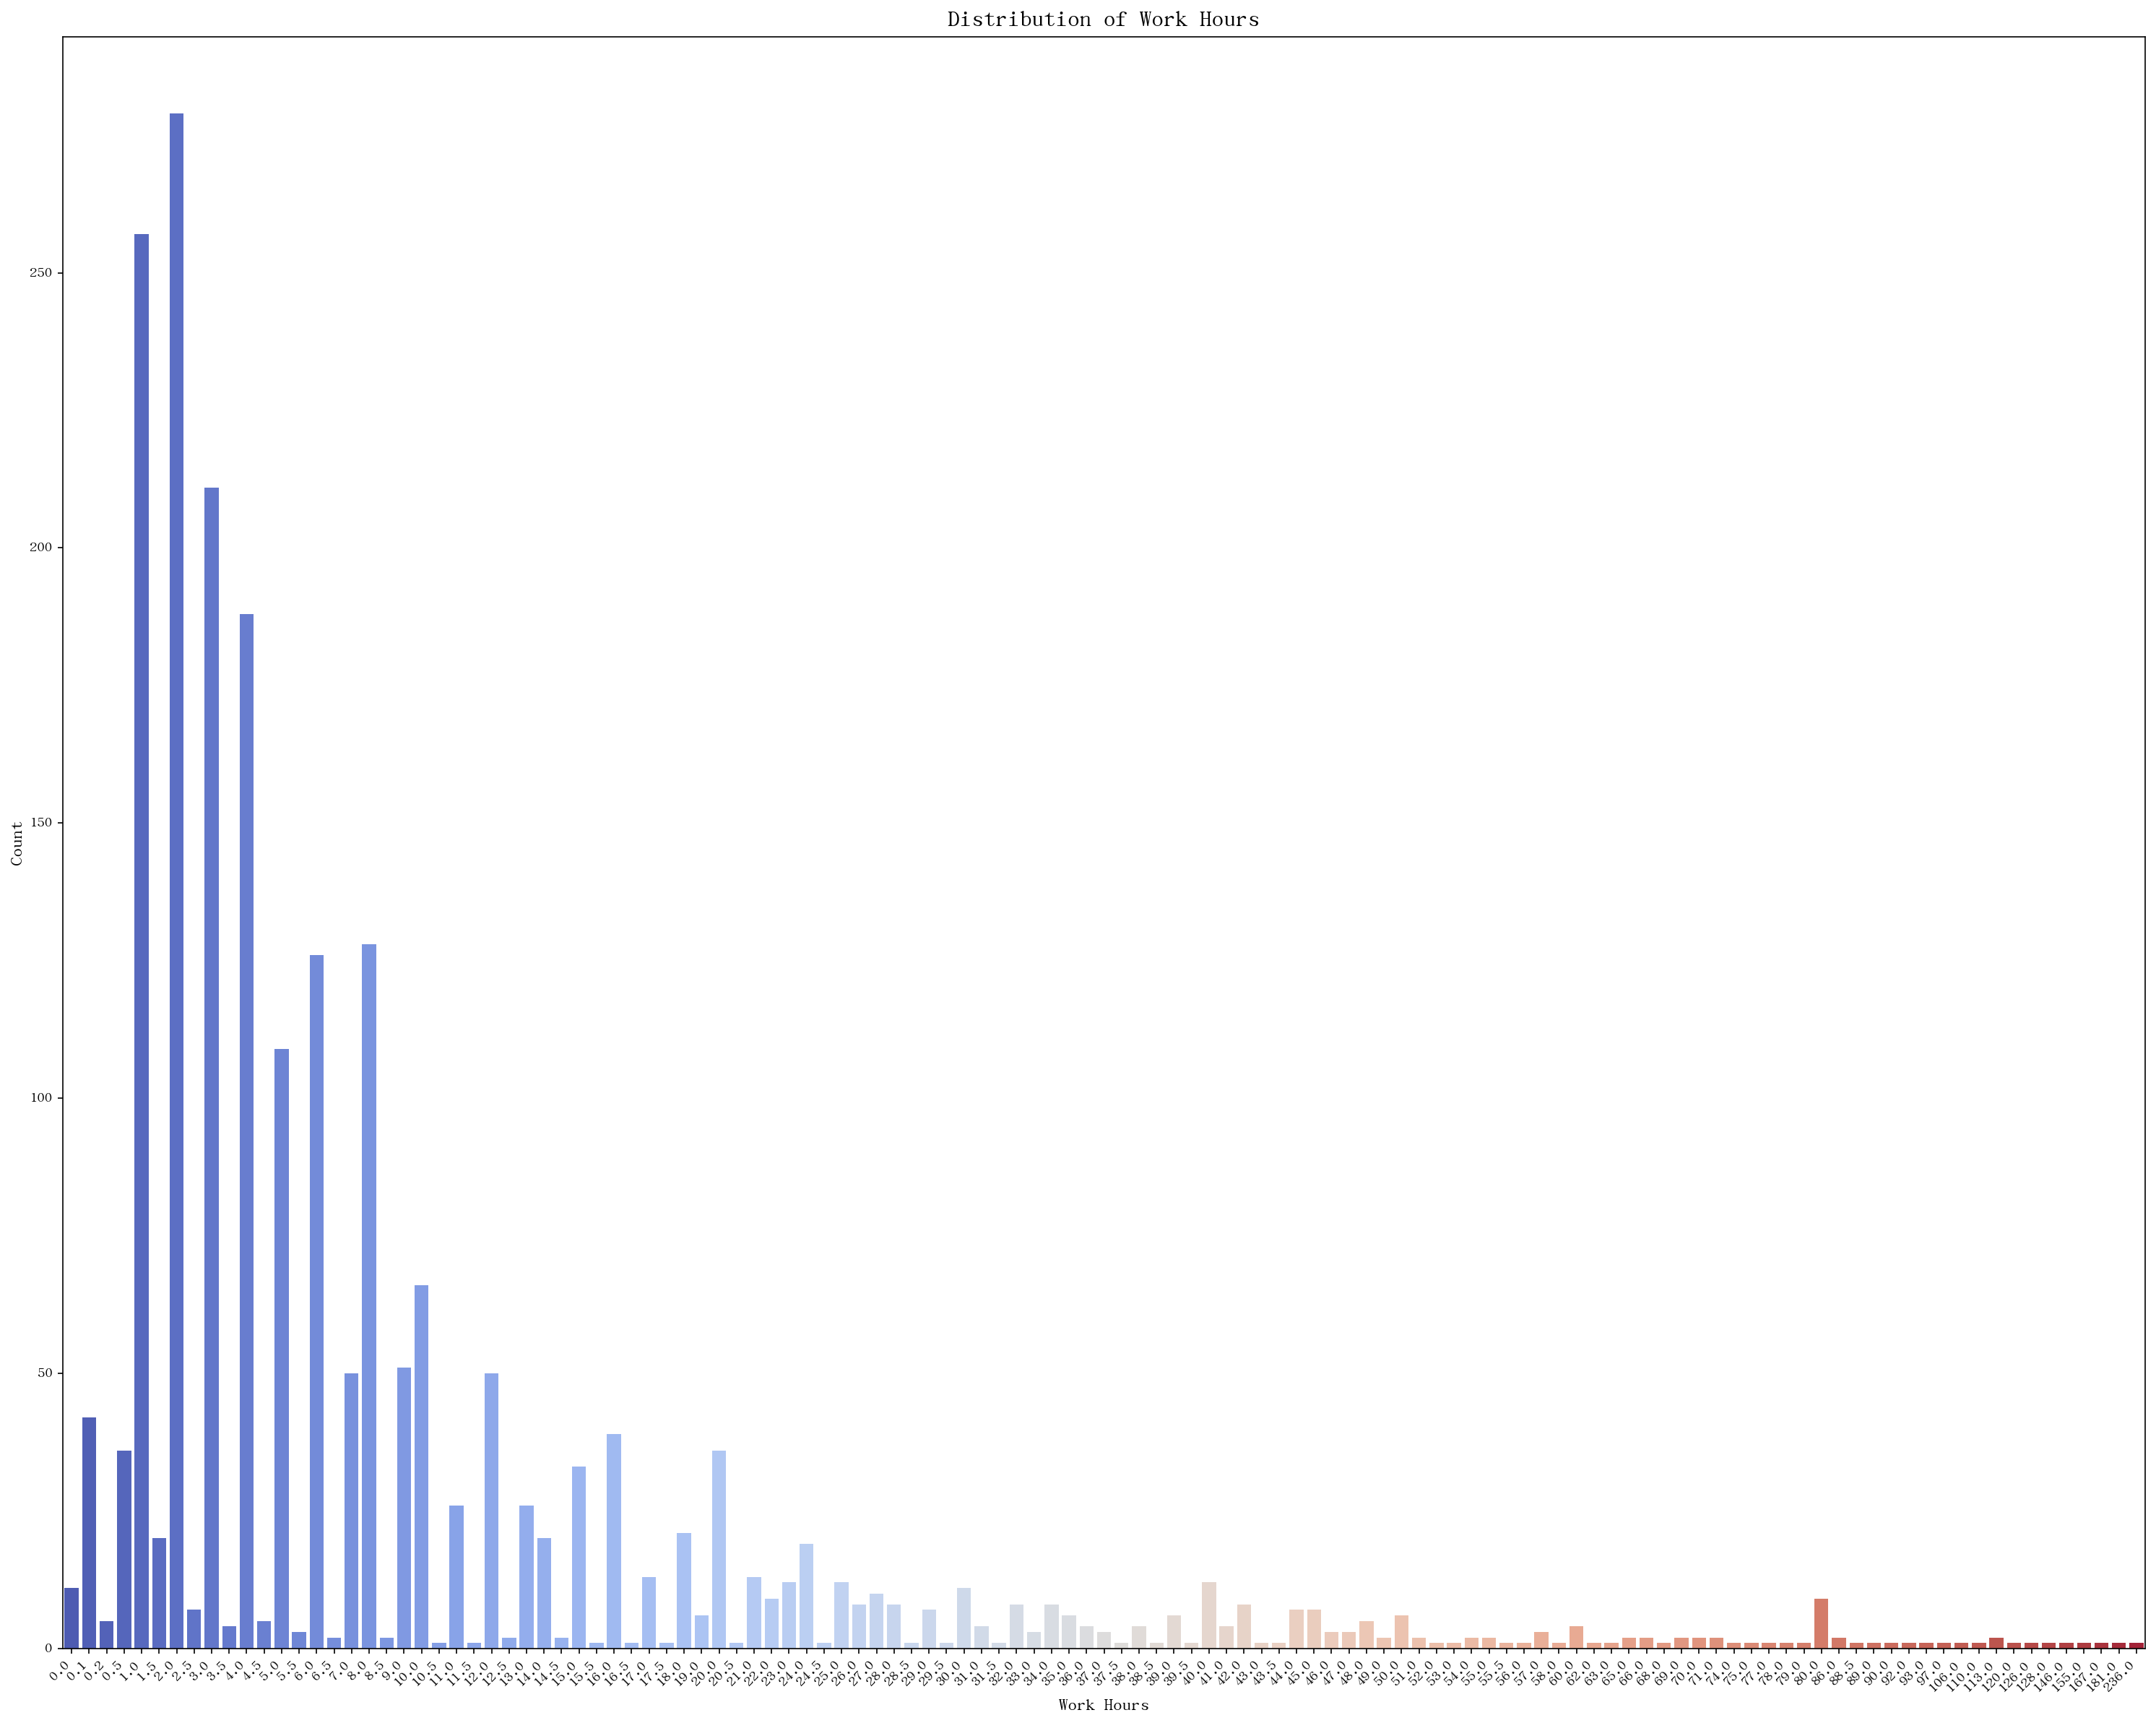

In [15]:
plt.figure(figsize=(20, 16), dpi=150)  # Adjust figure size if needed
sns.countplot(x='工时', data=hr_df, palette='coolwarm')  # Change palette as needed

# Set title and labels
plt.title('Distribution of Work Hours', fontsize=16)
plt.xlabel('Work Hours', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Optionally rotate x-tick labels for better readability if many values
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('Distribution of Work Hours.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
776/2168

0.35793357933579334

need rephrase: Around 65% of the company are working efficiently.

In [17]:
hr_df['labor_efficiency_log'] = np.log1p(hr_df['labor_efficiency'])

/tmp/ipykernel_78/2056624242.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


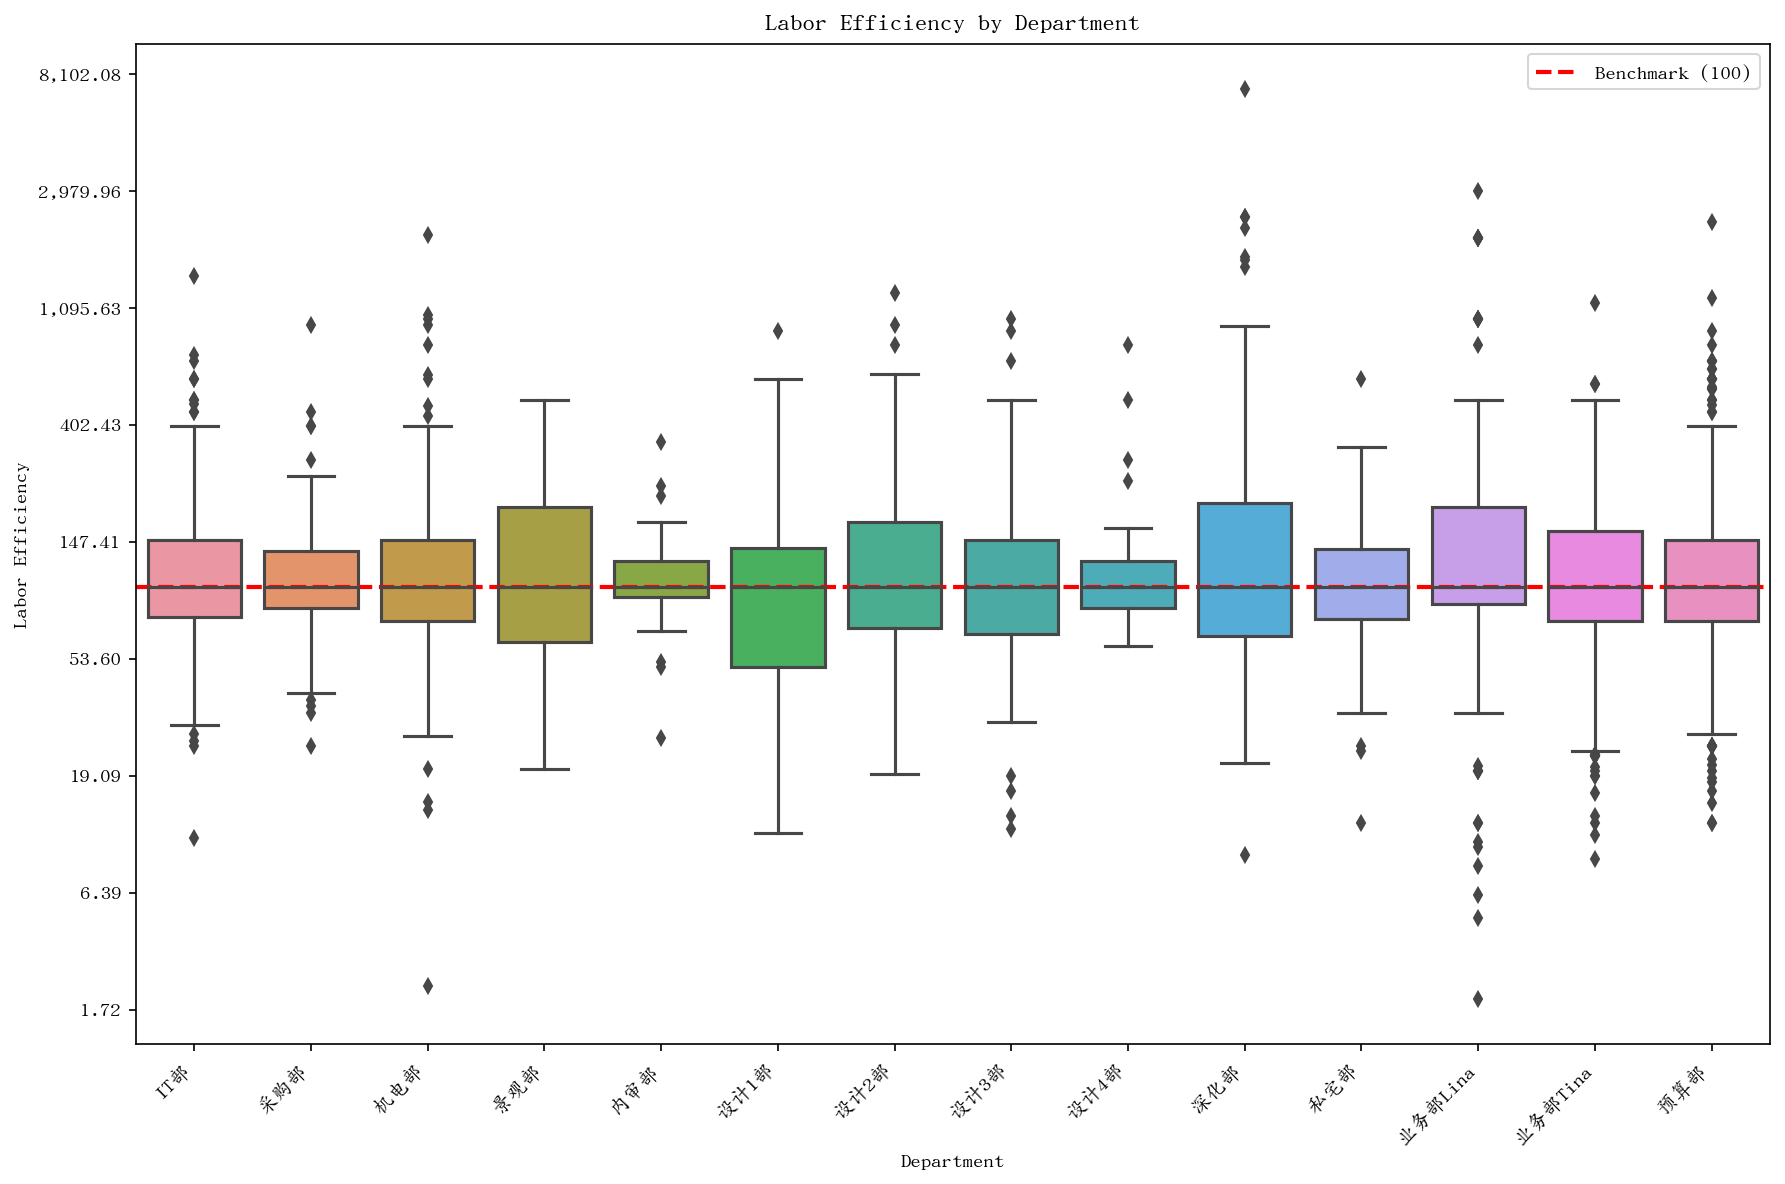

In [18]:
plt.figure(figsize=(12, 8), dpi=150)  # Set a higher DPI value to increase resolution
sns.color_palette("Paired")

sns.boxplot(x='部门', y='labor_efficiency_log', data=hr_df)

# Add a horizontal line at the benchmark of 100 (log-transformed)
benchmark_value = np.log1p(100)
plt.axhline(y=benchmark_value, color='red', linestyle='--', label='Benchmark (100)', linewidth=2)

# Set titles and labels
plt.title('Labor Efficiency by Department')
plt.xlabel('Department')
plt.ylabel('Labor Efficiency')

# Replace the y-axis labels with the actual efficiency values
y_ticks = plt.gca().get_yticks()  # Get current y-ticks (log-transformed values)
y_labels = np.expm1(y_ticks)  # Apply inverse of log1p to get original profit values
plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend for the benchmark line
plt.legend()

# Adjust the layout
plt.tight_layout()
plt.savefig('Labor Efficiency by All Department.png', dpi=300, bbox_inches='tight')
plt.show()

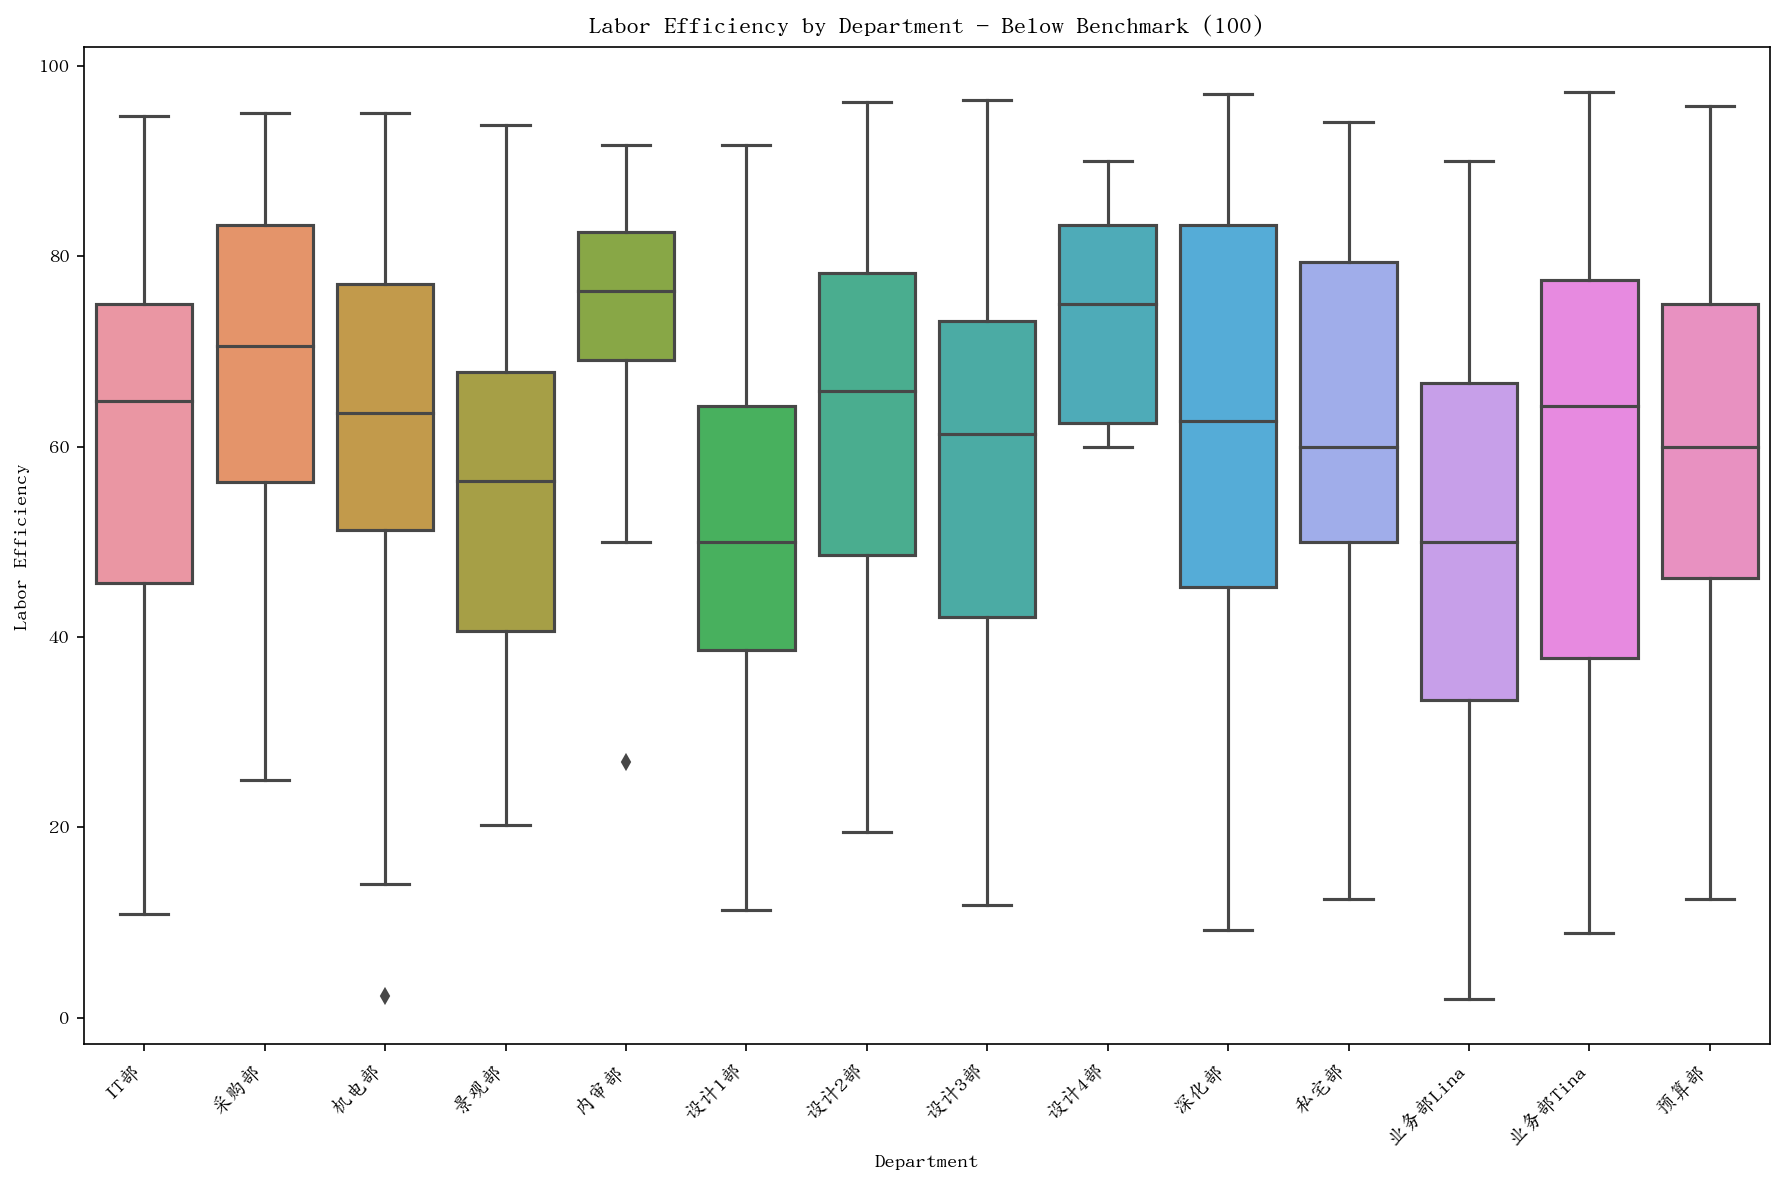

In [19]:
plt.figure(figsize=(12, 8), dpi=150)  # Set a higher DPI value to increase resolution
sns.color_palette("Paired")

sns.boxplot(x='部门', y='labor_efficiency', data=efficiency_outliers)

# Set titles and labels
plt.title('Labor Efficiency by Department - Below Benchmark (100)')
plt.xlabel('Department')
plt.ylabel('Labor Efficiency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('Labor Efficiency by Department - Below Benchmark (100).png', dpi=300, bbox_inches='tight')

plt.show()

**We want to match to gs and iss projects and revenue data**

**But first need to clean gs and iss**

In [20]:
def clean_project_id_and_name(df, id_column):
    # Function to validate project IDs based on your criteria
    def validate_project_id(project_id):
        # Check if the project ID has at least one letter and one number and contains only letters, numbers, and dashes
        if isinstance(project_id, str) and re.match(r'^[A-Z]+\d+-[A-Z\d]+$', project_id):
            return project_id
        else:
            return np.nan  # Return NaN for invalid formats
    
    # Clean the project IDs: remove spaces, convert to uppercase, and apply validation
    df[id_column] = df[id_column].str.strip().str.upper()
    df[id_column] = df[id_column].apply(validate_project_id)
    
    # Replace any NaN or invalid project IDs with NaN
    df[id_column].fillna(np.nan, inplace=True)

In [21]:
clean_project_id_and_name(gs, '项目编码')
clean_project_id_and_name(iss, '项目编码')

In [22]:
# Function to clean and convert money columns
def clean_money_columns(df, money_columns):
    for column in money_columns:
        # Remove ¥ symbol and commas, and convert to float
        df[column] = df[column].replace({'¥': '', ',': ''}, regex=True).astype(float)

In [23]:
clean_money_columns(gs, ['客户报价金额（元）', '采购成本（元）','盈利（元）'])
clean_money_columns(iss, ['合同金额', '项目采购成本','盈利（元）'])

In [24]:
gs.drop(columns=['Unnamed: 6', 'Unnamed: 7'], inplace=True)

gs 项目名称 also needs cleaning :(

In [25]:
# Source: https://blog.csdn.net/qq_30252319/article/details/53398429
city_abbv = ['北京市|beijing|bj','上海市|shanghai|sh','天津市|tianjin|tj','重庆市|chongqing|cq','长沙市|changsha|cs',
                 '长春市|changchun|cc','成都市|chengdu|cd','福州市|fuzhou|fz','广州市|guangzhou|gz',"贵阳市|guiyang|gy",
                 '合肥市|hefei|hf','杭州市|hangzhou|hz','昆明市|kunming|km','拉萨市|lasa|ls',"兰州市|lanzhou|lz",
                 '南宁市|nanning|nn','南京市|nanjing|nj','南昌市|nanchang|nc','沈阳市|shenyang|sy',"石家庄市|shijiazhuang|sjz",
                 '东莞市|dongguan|dg','中山市|zhongshan|zs','深圳市|shenzhen|sz','惠州市|huizhou|hz',"江门市|jiangmen|jm",
                 '珠海市|zhuhai|zh','汕头市|shantou|st','佛山市|foshan|fs','湛江市|zhanjiang|zj',"河源市|heyuan|hy",
                 '肇庆市|zhaoqing|zq','清远市|qingyuan|qy','潮州市|chaozhou|cz','韶关市|shaoguan|sg',"揭阳市|jieyang|jy",
                 '阳江市|yangjiang|yj','梅州市|meizhou|mz','云浮市|yunfu|yf','茂名市|maoming|mm',"汕尾市|shanwei|sw",
                 '济南市|jinan|jn','青岛市|qingdao|qd','临沂市|linyi|ly','茂名市|maoming|mm',"济宁市|jining|jn",
                 '菏泽市|heze|hz','烟台市|yantai|yt','淄博市|zibo|zb','泰安市|taian|ta',"潍坊市|weifang|wf",
                 '日照市|rizhao|rz','威海市|weihai|wh','滨州市|binzhou|bz','东营市|dongying|dy',"聊城市|liaocheng|lc",
                 '德州市|dezhou|dz','莱芜市|laiwu|lw','枣庄市|zaozhuang|zz','苏州市|suzhou|sz',"徐州市|xuzhou|xz",
                 '镇江市|zhenjiang|zj','扬州市|yangzhou|yz','淮安市|huaian|ha','泰州市|taizhou|tz',"宿迁市|suqian|sq",
                 '郑州市|zhengzhou|zz','南阳市|nanyang|ny','新乡市|xinxiang|xx','安阳市|anyang|ay',"洛阳市|luoyang|ly",
                 '信阳市|xinyang|xy','平顶山市|pingdingshan|pds','周口市|zhoukou|zk','商丘市|shangqiu|sq',"开封市|kaifeng|kf",
                 '焦作市|jiaozuo|jz','驻马店市|zhumadian|zmd','濮阳市|puyang|py','三门峡市|sanmenxia|smx',"漯河市|luohe|lh",
                 '许昌市|xuchang|xc','鹤壁市|hebi|hb','济源市|jiyuan|jy','唐山市|tangshan|ts',"保定市|baoding|bd",
                 '邯郸市|handan|hd','邢台市|xingtai|xt','沧州市|cangzhou|cz','秦皇岛|qinhuangdao|qhd',"张家口市|zhangjiakou|zjk",
                 '衡水市|hengshui|hs','廊坊市|langfang|lf','承德市|chengde|cd','温州市|wenzhou|wz',"宁波市|ningbo|nb",
                 '台州市|taizhou|tz','嘉兴市|jiaxing|jx','金华市|jinhua|jh','湖州市|huzhou|hz',"绍兴市|shaoxing|sx",
                 '舟山市|zhoushan|zs','丽水市|lishui|ls','衢州市|quzhou|qz','西安市|xian|xa',"咸阳市|xianyang|xy",
                 '宝鸡市|baoji|bj','汉中市|hanzhong|hz','渭南市|weinan|wn','榆林市|yulin|yl',"安康市|ankang|ak",
                 '商洛市|shangluo|sl','延安市|yanan|ya','铜川市|tongchuan|tc','邵阳市|shaoyang|sy',"常德市|changde|cd",
                 '衡阳市|hengyang|hy','株洲市|zhuzhou|zz','湘潭市|xiangtan|xt','永州市|yongzhou|yz',"岳阳市|yueyang|yy",
                 '怀化市|huaihua|hh','郴州市|chenzhou|cz','娄底市|loudi|ld','益阳市|yiyang|yy',"张家界市|zhangjiajie|zjj",
                 '湘西市|xiangxi|xx','漳州市|zhanghzou|zz','厦门市|xiamen|xm','泉州市|quanzhou|qz',"莆田市|putian|pt",
                 '宁德市|ningde|nd','三明市|sanming|sm','南平市|nanping|np','龙岩市|longyan|ly',"红河州|hohezhou|hhz",
                 '大理州|dalizhou|dlz','文山州|wenshanzhou|wsz','德宏州|dehongzhou|dhz','曲靖市|qujing|qj',"邵通市|shaotong|st",
                 '楚雄市|chuxiong|cx','宝山市|baoshan|bs','玉溪市|yuxi|yx','丽江地区|lijiangdiqu|ljdq',"临沧地区|lincangdiqu|lcdq",
                 '思茅地区|simaodiqu|smdq','西双版纳州|xishuangbannazhou|xsbnz','怒江州|nujiangzhou|njz','迪庆州市|diqingzhou|dqz',"绵阳市|mianyang|my",
                 '广元市|guangyuan|gy','达州市|dazhou|dz','南充市|nanchong|nc','德阳市|deyang|dy',"广安市|guangan|ga",
                 '阿坝州|abazhou|abz','巴中市|bazhong|bz','遂宁市|suining|sn','内江市|neijiang|nj',"凉山州|liangshanzhou|lsz",
                 '攀枝花市|panzhihua|pzh','乐山市|leshan|ls','自贡市|zigong|zg','泸州市|luzhou|lz',"雅安市|yaan|ya",
                 '宜宾市|yibin|yb','资阳市|ziyang|zy','眉山市|meishan|ms','甘孜市|ganzi|gz',"贵港市|guigang|gg",
                 '玉林市|yulin|yl','北海市|beihai|bh','柳州市|liuzhou|lz','桂林市|guilin|gl',"梧州市|wuzhou|wz",
                 '钦州市|qinzhou|qz','来宾市|laibin|lb','河池市|hechi|hc','百色市|baise|bs',"贺州市|hezhou|hz",
                 '崇左市|chongzuo|cz','防空港市|fangkonggan|fkg','芜湖市|wuhu|wh','六安市|luan|la',"宿州市|suzhou|sz",
                 '阜阳市|fuyang|fy','安庆市|anqing|aq','马鞍山市|maanshan|mas','蚌埠市|bengbu|bb',"淮北市|huaibei|hb",
                 '淮南市|huainan|hn','宣城市|xuancheng|xc','黄山市|huangshan|hs','铜陵市|tongling|tl',"毫州市|bozhou|bz",
                 '池州市|chizhou|cz','巢湖市|chaohu|ch','滁州市|chuzhou|cz','三亚市|sanya|sy',"海口市|haikou|hk",
                 '琼海市|qionghai|qh','文昌市|wenchang|wc','东方市|dongfang|df','昌江县|changjiangxian|cjx',"陵水县|lingshuixian|lsx",
                 '乐东县|ledongxian|ldx','保亭县|baotingxian|btx','五指山市|wuzhishan|wzs','澄迈县|chengmaixian|cmx',"万宁市|wanning|wn",
                 '儋州市|danzhou|dz','临高县|lingaoxian|lgx','白沙县|baishaxian|bsx','定安县|dinganxian|dax',"琼中县|qiongzhongxian|qzx",
                 '屯昌县|tunchangxian|tcx','赣州市|ganzhou|gz','上饶市|shangrao|sr','吉安市|jian|ja',"九江市|jiujiang|jj",
                 '新余市|xinyu|xy','抚州市|fuzhou|fz','宜春市|yichun|yc','景德镇市|jingdezhen|jdz',"萍乡市|pingxiang|px",
                 '鹰潭市|yingtan|yt','武汉市|wuhan|wh','宜昌市|yichang|yc','襄樊市|xiangfan|xf',"荆州市|jingzhou|jz",
                 '恩施市|enshi|es','黄冈市|huanggang|hg','孝感市|xiaogan|xg','十堰市|shiyan|sy',"咸宁市|xianning|xn",
                 '黄石市|huangshi|hs','仙桃市|xiantao|xt','天门市|tianmen|tm','随州市|suizhou|xz',"荆门市|jingmen|jm",
                 '潜江市|qianjiang|qj','鄂州市|ezhou|ez','神农架林区|shennongjialinqu|snjlq','太原市|taiyuan|ty',"大同市|datong|dt",
                 '运城市|yuncheng|yc','长治市|changzhi|cz','晋城市|jincheng|jc','忻州市|xinzhou|xz',"临汾市|linfen|lf",
                 '吕梁市|lvliang|ll','晋中市|jinzhong|jz','阳泉市|yangquan|yc','朔州市|shuozhou|sz',"大连市|dalian|dl",
                 '丹东市|dandong|dd','辽阳市|liaoyang|ly','葫芦岛市|huludao|hld','锦州市|jinzhou|jz',"朝阳市|chaoyang|cy",
                 '营口市|yingkou|yk','鞍山市|anshang|as','抚顺市|fushun|fs','阜新市|fuxin|fx',"盘锦市|panjin|pj",
                 '本溪市|benxi|bx','铁岭市|tieling|tl','齐齐哈尔市|qiqihaer|qqhe','大庆市|daqing|dq',"佳木斯市|jiamusi|jms",
                 '双鸭山市|shangyashan|sys','牡丹江市|mudanjiang|mdj','鸡西市|jixi|jx','黑河市|heihe|hh',"绥化市|suihua|sh",
                 '鹤岗市|hegang|hg','伊春市|yichun|yc','大兴安岭地区|daxinganlingdiqu|dxaldq','七台河市|qitaihe|qth',"哈尔滨市|haerbin|heb",
                 '赤峰市|chifeng|cf','包头市|baotou|bt','通辽市|tongliao|tl','呼和浩特市|huhehaote|hhht',"鄂尔多斯市|eerduosi|eeds",
                 '乌海市|wuhai|wh','呼伦贝尔市|hulunbeier|hlbe','兴安盟|xinganmeng|xam','巴彦淖尔盟|bayannaoermeng|bymem',"乌兰擦布盟|wulancabumeng|wlcbm",
                 '锡林郭勒盟|xilinguolemeng|xlglm','阿拉善盟|alashanmeng|alsm','黔东南州|qiandongnanzhou|qdnz','黔南州|qiannanzhou|qn',"黔西南州|qianxinanzhou|qxnz",
                 '遵义市|zunyi|zy','毕节地区|bijiediqu|bjdq','铜仁地区|tongrendiqu|trdq','安顺市|anshun|as',"六盘水市|liupanshui|lps",
                 '天水市|tianshui|ts','庆阳市|qingyan|qy','武威市|wuwei|ww','酒泉市|jiuquan|jq',"张掖市|zhangyeshi|zy",
                 '陇南地区|longnandiqu|lndq','白银市|baiyin|by','定西地区|dingxidiqu|dxdq','平凉市|pingliang|pl',"嘉峪关市|jiayuguan|jyg",
                 '临夏回族自治州|linxiahuizuzizhizhou|lxhzzzz','金昌市|jinchang|jc','甘南市|gannan|gn','西宁市|xining|xn',"海西州|haixizhou|hxz",
                 '海东地区|haidongdiqu|hddq','海北州|haibeizhou|hbz','果洛州|guoluozhou|glz','玉树州|yushuzhou|ysz',"黄南藏族自治州|huangnanzangzuzizhizhou|hnzzzzz",
                 '乌鲁木齐市|wulumuqi|wlmq','伊犁州|yilizhou|ylz','昌吉州|changjizhou|cjz','石河子市|shihezi|shz',"哈密地区|hamidiqu|hmdq",
                 '阿克苏地区|akesudiqu|aksdq','巴音郭楞州|bayinguolengzhou|byglz','喀什地区|kashidiqu|ksdq','塔城地区|tachengdiqu|tcdq',"克拉玛依市|kelamayi|klmy",
                 '和田地区|hetiandiqu|htdq','阿勒泰州|aletaizhou|altz','吐鲁番地区|tulufandiqu|tlfdq','阿拉尔市|alaer|ale',"博尔塔拉州|boertalazhou|betlz",
                 '五家渠市|wujiaqu|wjq','克孜勒苏州|kezilesuzhou|kzlsz','图木舒克市|tumushuke|ytmsk','拉萨市|lasa|ls',"山南地区|shannandiqu|sndq",
                 '林芝地区|linzhidiqu|yt','日喀则地区|rikazediqu|rkzdq','阿里地区|alidiqu|aldq','昌都地区|changdudiqu|cddq',"那曲地区|naqudiqu|nqdq",
                 '吉林市|jilin|jl','长春市|changchun|cc','白山市|baishan|bs','延边州|yanbianzhou|ybz',"白城市|baicheng|bc",
                 '松原市|songyuan|sy','辽源市|liaoyuan|ly','通化市|tonghua|th','四平市|siping|sp',"银川市|yinchuan|yc",
                 '吴中市|wuzhong|wz','中卫市|zhongwei|zw','石嘴山市|shizuishan|szs','固原市|guyuan|gy',"台湾|taiwan|tw",
                 '香港特别行政区|xianggang|xg','澳门特别行政区|aomen|am']
city_abbv_dict = {item.split('|')[0].replace('市', ''): item.split('|')[2].upper() for item in city_abbv}

In [26]:
def clean_project_name(df, column_name='项目名称'):        
    # Remove project IDs (like GS230045BJ07):
    def remove_id(text):
        return re.sub(r'[A-Z]+\d+-[A-Z\d]+', '', text).strip()
    
    df[column_name] = df[column_name].apply(remove_id)
    df[column_name] = df[column_name].str.replace(r'\s+', '')  # Replace multiple spaces with ''
    # Reformat project names into "地名 + 公司名称 + 具体项目":
    def restructure_name(text):
        pattern = r'(.*?)-(.*?)-(.*)'
        match = re.match(pattern, text)
        if match:
            company, city, project = match.groups()
            value = 0
            value = {i for i in city_abbv_dict if city_abbv_dict[i]==city}
            if value:
                english_city = list(value)[0]  # An abbrevation can match many cities. We just assume that the near front cities are the most likely one
                return f'{english_city}{city}{company.strip()}{project.strip()}'
        return text  # If it doesn't match the pattern, return the text as is
    
    df[column_name] = df[column_name].apply(restructure_name)
    
    # Remove special characters (non-word, non-space):
    df[column_name] = df[column_name].str.replace('[^\w\s]', '', regex=True)
        
    # Remove leading/trailing spaces:
    df[column_name] = df[column_name].str.replace(r'\s+', '')  # Replace multiple spaces with one
    
    return df
gs = clean_project_name(gs)
hr_df = clean_project_name(hr_df)
iss = clean_project_name(iss)

**Now merge three datasets on 项目编码 OR 项目名称**

In [27]:
# Add helper columns to indicate the origin of the data
gs['匹配'] = 'GS'
iss['匹配'] = 'ISS'

# Perform the first merge between hr_df and gs
merged_df = pd.merge(hr_df, gs, how='outer', on=['项目编码', '项目名称'], suffixes=('', '_gs'))
# Perform the second merge between the merged result and iss
merged_df = pd.merge(merged_df, iss, how='outer', on=['项目编码', '项目名称'], suffixes=('', '_iss'))

# Now handle the 匹配 column
def determine_match(row):
    # Check if the row has data from both GS and ISS by checking the 匹配 column
    gs_match = pd.notnull(row['匹配'])  # Check for GS match
    iss_match = pd.notnull(row['匹配_iss'])  # Check for ISS match
    
    if gs_match and iss_match:
        return 'GS + ISS'
    elif gs_match:
        return 'GS'
    elif iss_match:
        return 'ISS'
    else:
        return 'No Match'

# Apply this logic to generate the final 匹配 column
merged_df['匹配'] = merged_df.apply(determine_match, axis=1)

# You can now drop the helper columns ('匹配_gs' and '匹配_iss') if they are no longer needed
# merged_df = merged_df.drop(columns=['匹配_gs', '匹配_iss'])
merged_df = merged_df.drop(columns=['匹配_iss'])

# Now merged_df will have the new 匹配 column with the origin information

In [28]:
merged_df.columns

Index(['日期', '项目', '阶段', '部门', '具体任务', '工时', '项目编码', '项目名称', 'mean_hr',
       'benchmark_hr', 'std_hr', 'amount', 'upper_bound', 'lower_bound',
       'labor_efficiency', 'labor_efficiency_log', '客户报价金额（元）', '采购成本（元）',
       '盈利（元）', '谈判状态', '匹配', '合同金额', '项目采购成本', '盈利（元）_iss'],
      dtype='object')

In [29]:
# Combine the duplicated columns
merged_df['客户报价金额（元）'] = merged_df['客户报价金额（元）'].fillna(merged_df['合同金额'])
merged_df['采购成本（元）'] = merged_df['采购成本（元）'].fillna(merged_df['项目采购成本'])
merged_df['盈利（元）'] = merged_df['盈利（元）'].fillna(merged_df['盈利（元）_iss'])

merged_df.drop(['项目采购成本', '盈利（元）_iss', '合同金额', '项目'], axis=1, inplace=True)
merged_df.rename(columns={'客户报价金额（元）': '收益（元）'}, inplace=True)

In [30]:
merged_df.to_csv('merged.csv')

In [31]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   日期                    2168 non-null   object 
 1   项目                    2168 non-null   object 
 2   阶段                    680 non-null    object 
 3   部门                    2168 non-null   object 
 4   具体任务                  2079 non-null   object 
 5   工时                    2168 non-null   float64
 6   项目编码                  1744 non-null   object 
 7   项目名称                  2168 non-null   object 
 8   mean_hr               2168 non-null   float64
 9   benchmark_hr          2168 non-null   float64
 10  std_hr                1962 non-null   float64
 11  amount                2168 non-null   int64  
 12  upper_bound           1962 non-null   float64
 13  lower_bound           1962 non-null   float64
 14  labor_efficiency      2168 non-null   float64
 15  labor_efficiency_log 

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   日期                    2168 non-null   object 
 1   阶段                    680 non-null    object 
 2   部门                    2168 non-null   object 
 3   具体任务                  2079 non-null   object 
 4   工时                    2168 non-null   float64
 5   项目编码                  1834 non-null   object 
 6   项目名称                  2318 non-null   object 
 7   mean_hr               2168 non-null   float64
 8   benchmark_hr          2168 non-null   float64
 9   std_hr                1962 non-null   float64
 10  amount                2168 non-null   float64
 11  upper_bound           1962 non-null   float64
 12  lower_bound           1962 non-null   float64
 13  labor_efficiency      2168 non-null   float64
 14  labor_efficiency_log  2168 non-null   float64
 15  收益（元）                

**reload new merged_df after running NLP on the other notebook.**

In [33]:
merged_df = pd.read_csv('merged_with_similarity_results.csv')

In [34]:
merged_df[
    (~pd.isna(merged_df['Name_Name_GS_Similarity']) & (merged_df['Name_Name_GS_Similarity'] != 0)) |
    (~pd.isna(merged_df['Name_Name_ISS_Similarity']) & (merged_df['Name_Name_ISS_Similarity'] != 0)) | 
    (~pd.isna(merged_df['Desc_Name_ISS_Similarity']) & (merged_df['Desc_Name_ISS_Similarity'] != 0))
][[
    '部门','具体任务', '项目编码', '项目名称', 'Name_Name_Match_GS', 'Name_Name_GS_Similarity', 'Name_Name_Match_ISS', 'Name_Name_ISS_Similarity', 'Desc_Name_Match_ISS', 'Desc_Name_ISS_Similarity'
]].rename(columns={'Desc_Name_Match_ISS': 'Description_Name_Match_ISS'}).to_csv('all_nlp_results.csv', index=False, encoding='utf-8-sig')

In [35]:
approved_iss_matching = merged_df[merged_df['Name_Name_ISS_Similarity'] > 0.85]['Name_Name_Match_ISS']
for i in range(0, len(iss)):
    ind_lis = approved_iss_matching.index
    j = 0
    for name in approved_iss_matching:
        if iss['项目名称'][i] == name:
            merged_df.loc[ind_lis[j], '项目名称'] = name
            merged_df.loc[ind_lis[j], '采购成本（元）'] = iss['项目采购成本'].iloc[i]
            merged_df.loc[ind_lis[j], '收益（元）'] = iss['合同金额'].iloc[i]
            merged_df.loc[ind_lis[j], '盈利（元）'] = iss['盈利（元）'].iloc[i]
            j += 1

In [36]:
approved_gs_matching = merged_df[merged_df['Name_Name_GS_Similarity'] > 0.85]['Name_Name_Match_GS']
for i in range(0, len(gs)):
    ind_lis = approved_gs_matching.index
    j = 0
    for name in approved_gs_matching:
        if gs['项目名称'][i] == name:
            merged_df.loc[ind_lis[j], '项目名称'] = name
            merged_df.loc[ind_lis[j], '采购成本（元）'] = gs['采购成本（元）'].iloc[i]
            merged_df.loc[ind_lis[j], '收益（元）'] = gs['客户报价金额（元）'].iloc[i]
            merged_df.loc[ind_lis[j], '盈利（元）'] = gs['盈利（元）'].iloc[i]
            merged_df.loc[ind_lis[j], '谈判状态'] = gs['谈判状态'].iloc[i]
            j += 1

In [37]:
merged_df.drop(['匹配', 'Desc_Name_Match_ISS', 'Desc_Name_ISS_Similarity', 'Name_Name_Match_GS', 'Name_Name_GS_Similarity', 'Name_Name_Match_ISS', 'Name_Name_ISS_Similarity'], axis=1, inplace=True)

In [38]:
output = merged_df.drop(columns=['mean_hr', 'benchmark_hr', 'std_hr', 'amount', 'upper_bound', 'lower_bound', 'labor_efficiency_log'])

In [39]:
output.to_csv('task_project_matching.csv', index=False, encoding='utf-8-sig')

**Now, planning to visualize.**

In [40]:
filtered_df = merged_df[(merged_df['工时'].notna()) & (merged_df['收益（元）'].notna())].reset_index(drop=True)

In [41]:
# Calculate efficiency (profit per work hour)
filtered_df['profit_efficiency'] = filtered_df['盈利（元）'] / filtered_df['工时']

In [42]:
sumed_df = filtered_df.groupby(['项目名称', '部门']).agg(
    total_work_hours=('工时', 'sum'),
    median_labor_efficiency=('labor_efficiency', 'median'),
    profit=('盈利（元）', 'first'),
    revenue=('收益（元）', 'first')
).reset_index()

# Calculate Efficiency as total_profit / total_work_hours
sumed_df['profit_efficiency'] = sumed_df['profit'] / sumed_df['total_work_hours']

# Display the result
sumed_df.head()

项目名称   部门  total_work_hours  median_labor_efficiency  profit  \
0  2024年金尚源改造  IT部              10.0               133.333333  404.53   
1  2024年金尚源改造  内审部              24.0               104.166667  404.53   
2  2024年金尚源改造  景观部              12.0               100.000000  404.53   
3  2024年金尚源改造  机电部               3.0               112.500000  404.53   
4  2024年金尚源改造  采购部               6.0               100.000000  404.53   

   revenue  profit_efficiency  
0  5513.65          40.453000  
1  5513.65          16.855417  
2  5513.65          33.710833  
3  5513.65         134.843333  
4  5513.65          67.421667

**There are a few negative profit, which causes efficiency to be negative, and if we want to calculate any log of efficiency, it will be 0, and cannot show difference. See below for example. So we want to `negative efficiency - minimum efficiency` to rescale the efficiency column.**

In [43]:
sumed_df[sumed_df['profit_efficiency'] <= 0].head()

项目名称       部门  total_work_hours  \
5  上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目      IT部              52.0   
6  上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目  业务部Tina             208.0   
7  上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目      内审部               6.0   
8  上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目      机电部              69.0   
9  上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目     设计4部             420.0   

   median_labor_efficiency     profit     revenue  profit_efficiency  
5               100.000000 -260072.04  3330791.81       -5001.385385  
6               100.595238 -260072.04  3330791.81       -1250.346346  
7               100.000000 -260072.04  3330791.81      -43345.340000  
8               100.277778 -260072.04  3330791.81       -3769.160000  
9               104.166667 -260072.04  3330791.81        -619.219143

In [44]:
min_eff = min(sumed_df[sumed_df['profit_efficiency'] <= 0]['profit_efficiency'])
sumed_df['rescaled_profit_efficiency'] = sumed_df['profit_efficiency'] - min_eff
sumed_df['logged_rescaled_profit_efficiency'] = np.log1p(sumed_df['rescaled_profit_efficiency'])
min_prof = min(sumed_df[sumed_df['profit'] <= 0]['profit'])
sumed_df['rescaled_profit'] = sumed_df['profit'] - min_prof
sumed_df['logged_rescaled_profit'] = np.log1p(sumed_df['rescaled_profit'])

# cap the profit_efficiency at the 95th percentile and floor it at the 5th percentile
# this is for the purpose of automation
sumed_df['winsorized_logged_rescaled_profit_efficiency'] = mstats.winsorize(sumed_df['logged_rescaled_profit_efficiency'], limits=[0.05, 0.05])

In [45]:
unique_data = sorted(set(sumed_df['logged_rescaled_profit']))
# Get the second smallest value
second_min = unique_data[1]

In [46]:
min_profit = sumed_df['logged_rescaled_profit'].min()

/tmp/ipykernel_78/721835677.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(label):,}' for label in y_labels])  # Set the new labels as original profit values


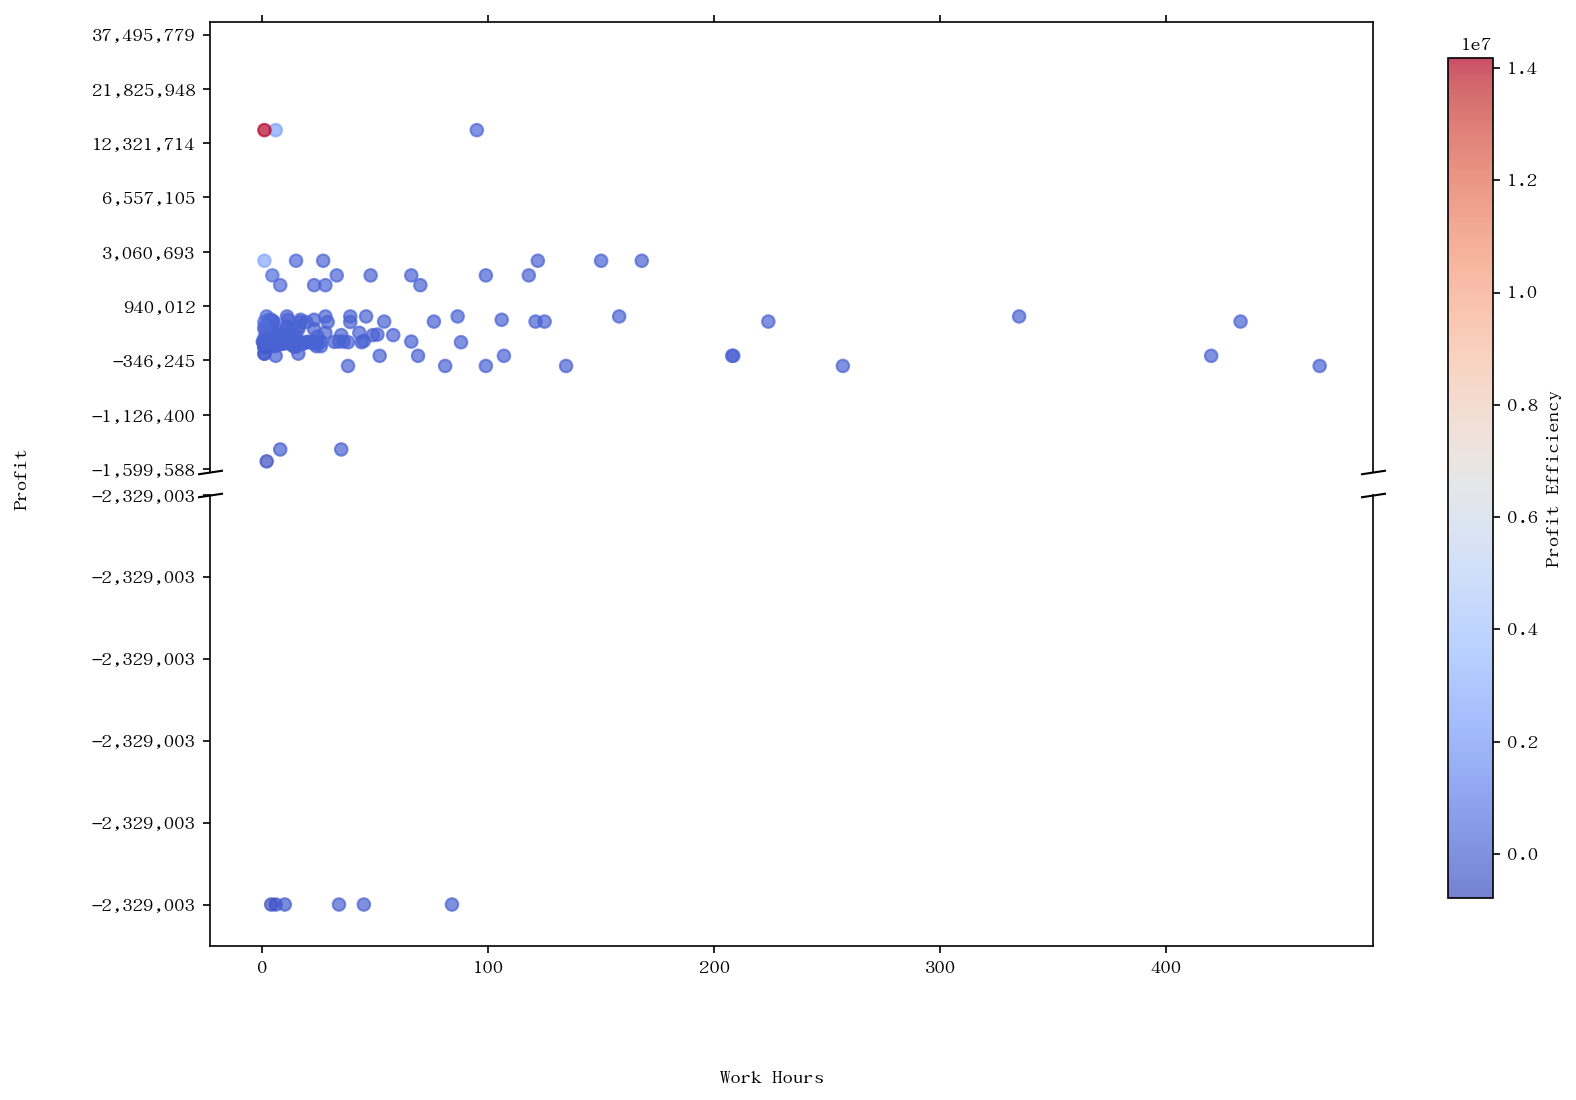

<Figure size 800x300 with 0 Axes>

In [47]:
# Create a figure and two subplots (for broken y-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), dpi=150)

# Adjust the space between the subplots
fig.subplots_adjust(hspace=0.05)
plt.figure(figsize=(8, 3))

# Plot scatter for each subplot
sc = ax1.scatter(sumed_df['total_work_hours'], sumed_df['logged_rescaled_profit'], c=sumed_df['profit_efficiency'], cmap='coolwarm', alpha=0.7)
sc = ax2.scatter(sumed_df['total_work_hours'], sumed_df['logged_rescaled_profit'], c=sumed_df['profit_efficiency'], cmap='coolwarm', alpha=0.7)

# Set y-limits for each subplot (simulating a broken y-axis)
ax2.set_ylim(-0.001, 0.01)  # Outliers
ax1.set_ylim(second_min-0.1, sumed_df['logged_rescaled_profit'].max()+1)  # Main data

# Hide the spines between ax1 and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add a diagonal line to indicate the broken axis
d = .15  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Add a color bar in a separate axis
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Profit Efficiency')

fig.text(0.5, 0, 'Work Hours', ha='center', va='center')
fig.text(0, 0.5, 'Profit', ha='center', va='center', rotation='vertical')

# Adjust y-ticks for both subplots to display the original profit values
for ax in [ax1, ax2]:
    y_ticks = ax.get_yticks()  # Get current y-ticks (log scale)
    y_labels = np.expm1(y_ticks) + min_prof  # Apply inverse of log1p to get original profit values
    ax.set_yticklabels([f'{int(label):,}' for label in y_labels])  # Set the new labels as original profit values

# Adjust layout to fit color bar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('Before Classification Profit vs. Work Hours by Project.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_78/2557106410.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


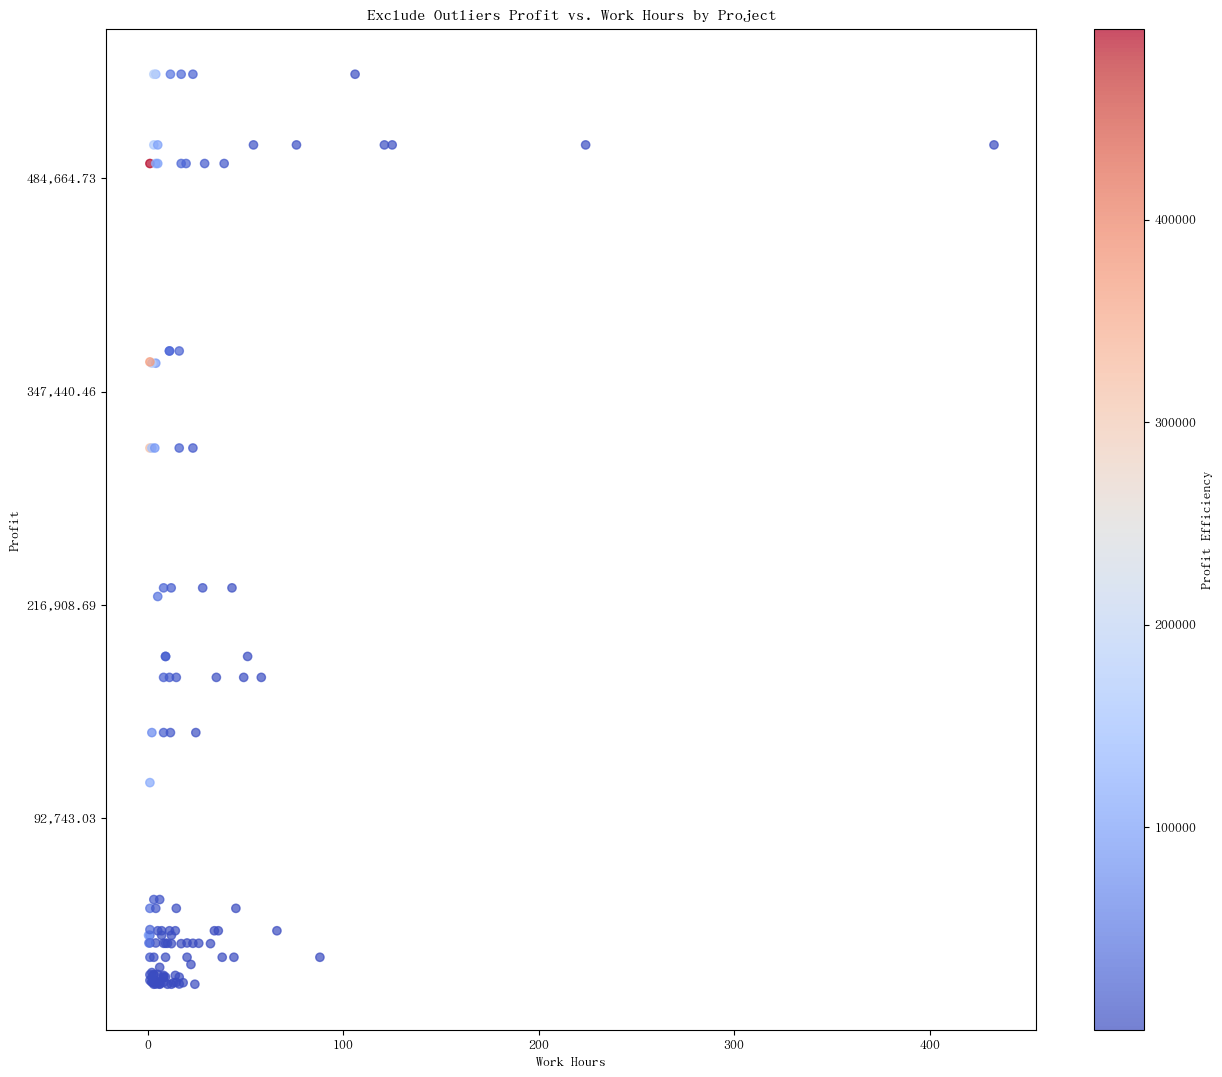

In [48]:
# Scatter plot of Profit vs. Work Hours with department as color/size
enlarged_df = sumed_df[(sumed_df['logged_rescaled_profit'] > 14.661) & (sumed_df['logged_rescaled_profit'] <= 14.9)]
plt.figure(figsize=(15, 13))
plt.scatter(enlarged_df['total_work_hours'], enlarged_df['logged_rescaled_profit'], alpha=0.7, c=enlarged_df['profit_efficiency'], cmap='coolwarm')

# Replace the y-axis labels with the actual efficiency values
y_ticks = plt.gca().get_yticks()  # Get current y-ticks (log-transformed values)
y_labels = np.expm1(y_ticks) + min_prof  # Apply inverse of log1p to get original profit values
plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])

plt.title('Exclude Outliers Profit vs. Work Hours by Project')
plt.xlabel('Work Hours')
plt.ylabel('Profit')
plt.colorbar(label='Profit Efficiency')
plt.savefig('Exclude Outliers Profit vs. Work Hours by Project.png', dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_78/3539396074.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


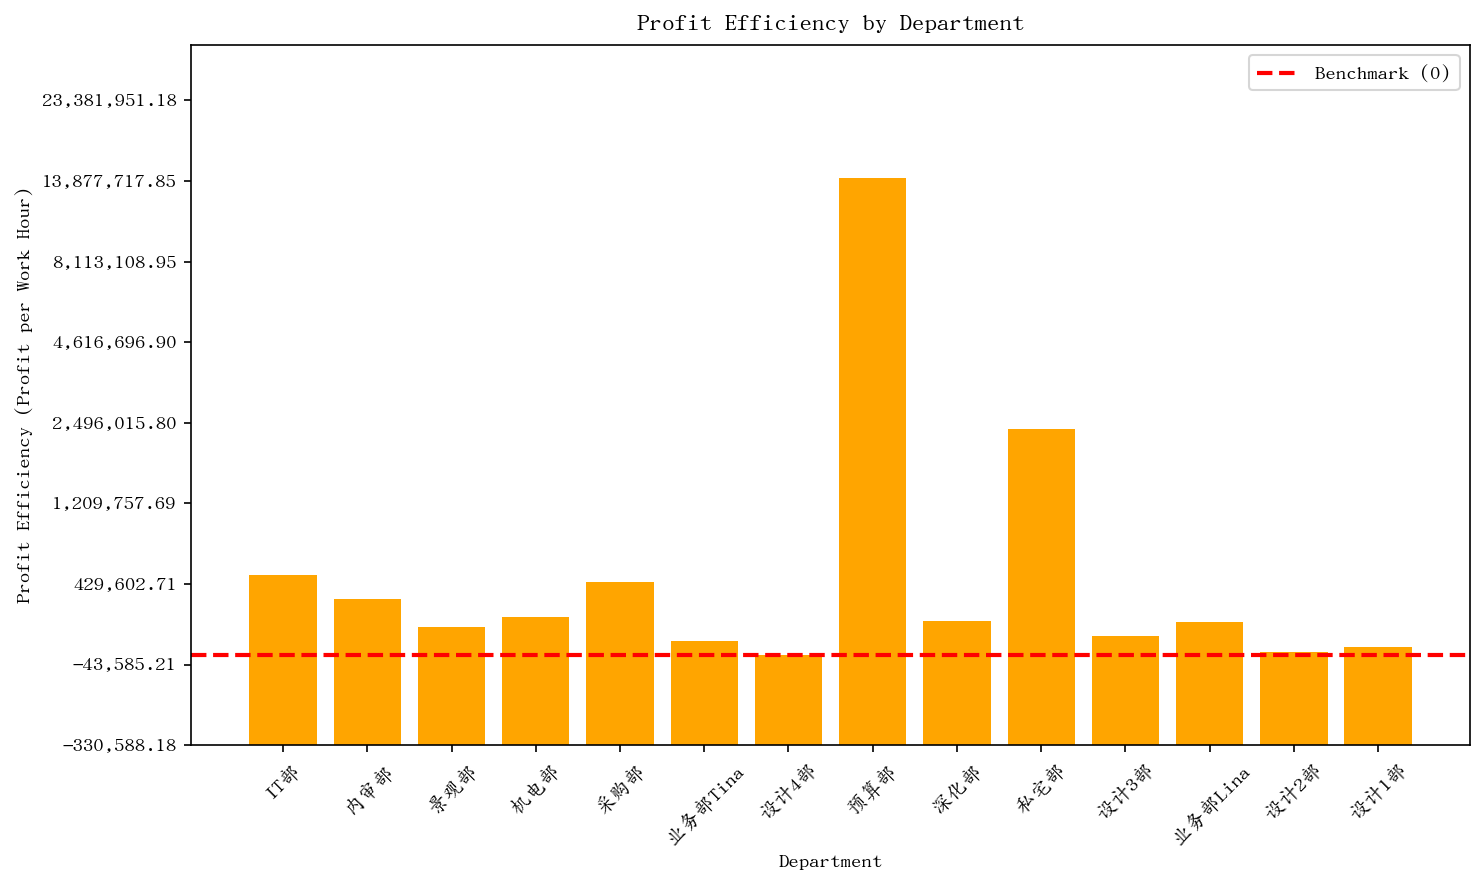

In [49]:
# Plot Efficiency vs Department
plt.figure(figsize=(10, 6), dpi=150)
plt.bar(sumed_df['部门'], sumed_df['logged_rescaled_profit_efficiency'], color='orange')

# Add labels and title
plt.xlabel('Department')
plt.ylabel('Profit Efficiency (Profit per Work Hour)')
plt.title('Profit Efficiency by Department')
plt.ylim(13, None)

# Replace the y-axis labels with the actual efficiency values
y_ticks = plt.gca().get_yticks()  # Get current y-ticks (log-transformed values)
y_labels = np.expm1(y_ticks) + min_eff  # Apply inverse of log1p to get original profit values
plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])

benchmark_value = np.log1p(0 - min_eff)
plt.axhline(y=benchmark_value, color='red', linestyle='--', label='Benchmark (0)', linewidth=2)
plt.legend()

# Rotate x-axis labels for better readability if department names are long
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Profit Efficiency by Department.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
sumed_df.head(1)

项目名称   部门  total_work_hours  median_labor_efficiency  profit  \
0  2024年金尚源改造  IT部              10.0               133.333333  404.53   

   revenue  profit_efficiency  rescaled_profit_efficiency  \
0  5513.65             40.453                  773041.028   

   logged_rescaled_profit_efficiency  rescaled_profit  logged_rescaled_profit  \
0                          13.558089       2329408.13               14.661125   

   winsorized_logged_rescaled_profit_efficiency  
0                                     13.558089

In [51]:
sumed_df.groupby('项目名称')[['profit']].first()

profit
项目名称                                            
2024年金尚源改造                                404.53
上海虹口区友邦金融大厦26层2601室2608及2609室营销中心新建项目 -260072.04
世贸国际公寓设计施工项目                           553987.96
东莞松山湖中集智谷28栋3层MAG华为黄区ODC场地门禁改造项目        -3893.35
东莞松山湖中集智谷28栋4层MAG新凯来业务ODC场地退租项目           503.77
...                                          ...
重庆两江新区互联网产业园2期6号楼5层8层TTR及DOS场地退租项目      30398.46
重庆两江新区互联网产业园二期6号楼1112层DOS场地改造项目         -4599.03
长沙岳麓区芯城科技园2栋24层MAG门禁系统升级改造项目            -2355.60
长沙高新区麓谷信息港B栋14层开放区改蓝区项目                  4209.65
阿里华谊兄弟办公室餐饮办公会所设计项目                   -444230.93

[82 rows x 1 columns]

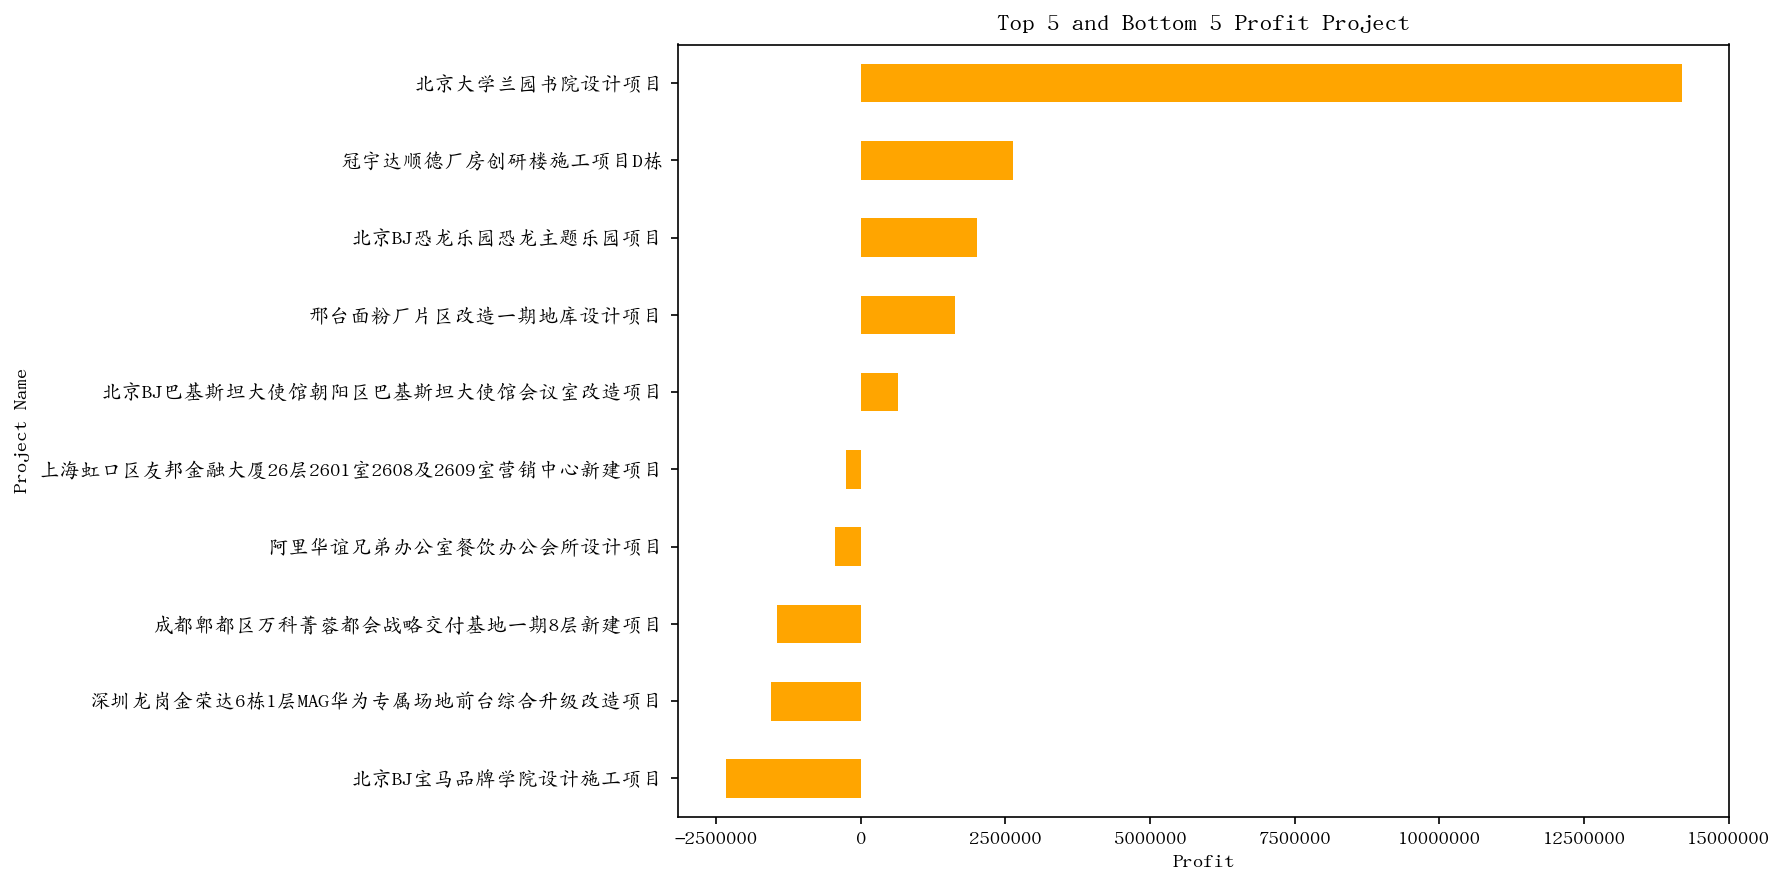

In [52]:
# Plot profit by project
grouped_by_project = sumed_df.groupby('项目名称')[['profit']].first()
top_bottom_n = 5
profit = pd.concat([grouped_by_project.nsmallest(top_bottom_n, 'profit'), 
                             grouped_by_project.nlargest(top_bottom_n, 'profit')])
profit = profit.sort_values('profit')

plt.figure(figsize=(12, 6), dpi=150)  # Adjust figure size
profit['profit'].plot(kind='barh', color='orange')

# Add labels and title
plt.xlabel('Profit')
plt.ylabel('Project Name')
plt.title('Top 5 and Bottom 5 Profit Project')

# Format the y-axis to remove scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

# Show the plot
plt.tight_layout()
plt.savefig('Profit Ranking by Project.png', dpi=300, bbox_inches='tight')
plt.show()

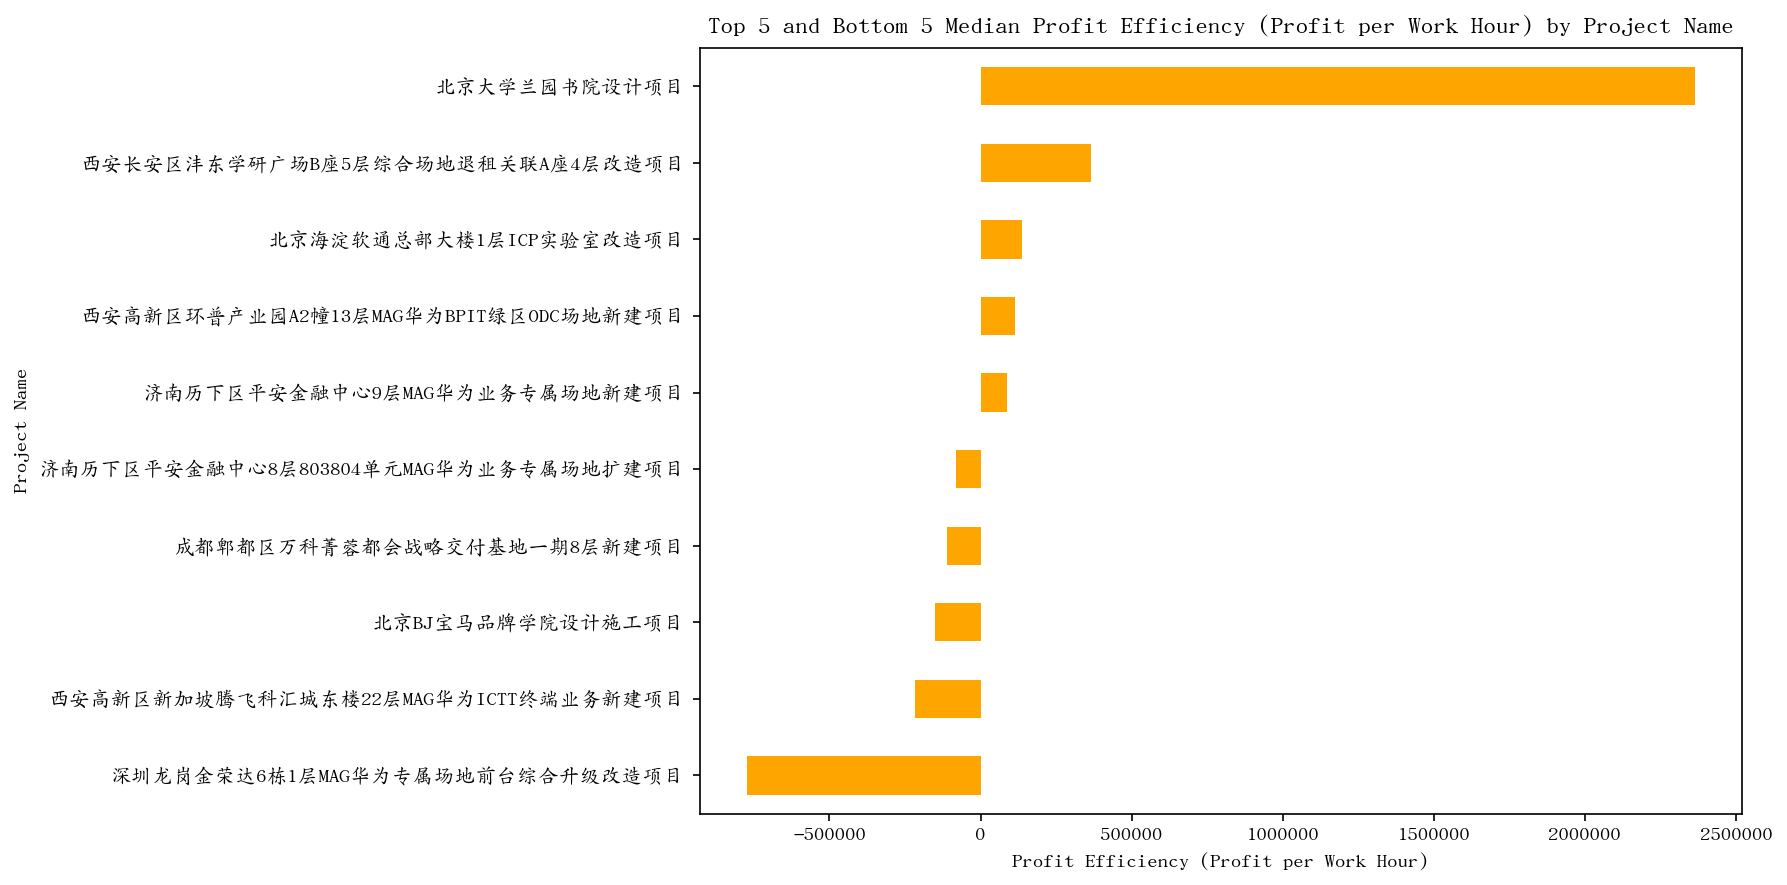

In [53]:
# Calculate the mean of efficiency by project
median_by_project = sumed_df.groupby('项目名称')['profit_efficiency'].median().reset_index()

# Sort by efficiency and select top 5 and bottom 5
top_bottom_n = 5
median_by_project = pd.concat([median_by_project.nsmallest(top_bottom_n, 'profit_efficiency'), 
                             median_by_project.nlargest(top_bottom_n, 'profit_efficiency')])
median_by_project = median_by_project.sort_values('profit_efficiency')
# Plot Efficiency by Project (bar plot)
plt.figure(figsize=(12, 6), dpi=150)  # Adjust figure size

median_by_project.set_index('项目名称')['profit_efficiency'].plot(kind='barh', color='orange')

# Format the x-axis to remove scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

# Rotate the y-axis labels to prevent overlap
plt.gca().tick_params(axis='y', labelsize=8)  # Adjust label size if necessary
plt.yticks(rotation=0, ha='right', fontsize=10)  # Adjust rotation and font size for better readability

# Set title and labels
plt.title('Top 5 and Bottom 5 Median Profit Efficiency (Profit per Work Hour) by Project Name')
plt.xlabel('Profit Efficiency (Profit per Work Hour)')
plt.ylabel('Project Name')

# Adjust layout
plt.tight_layout()
plt.savefig('Profit Efficiency by Project.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

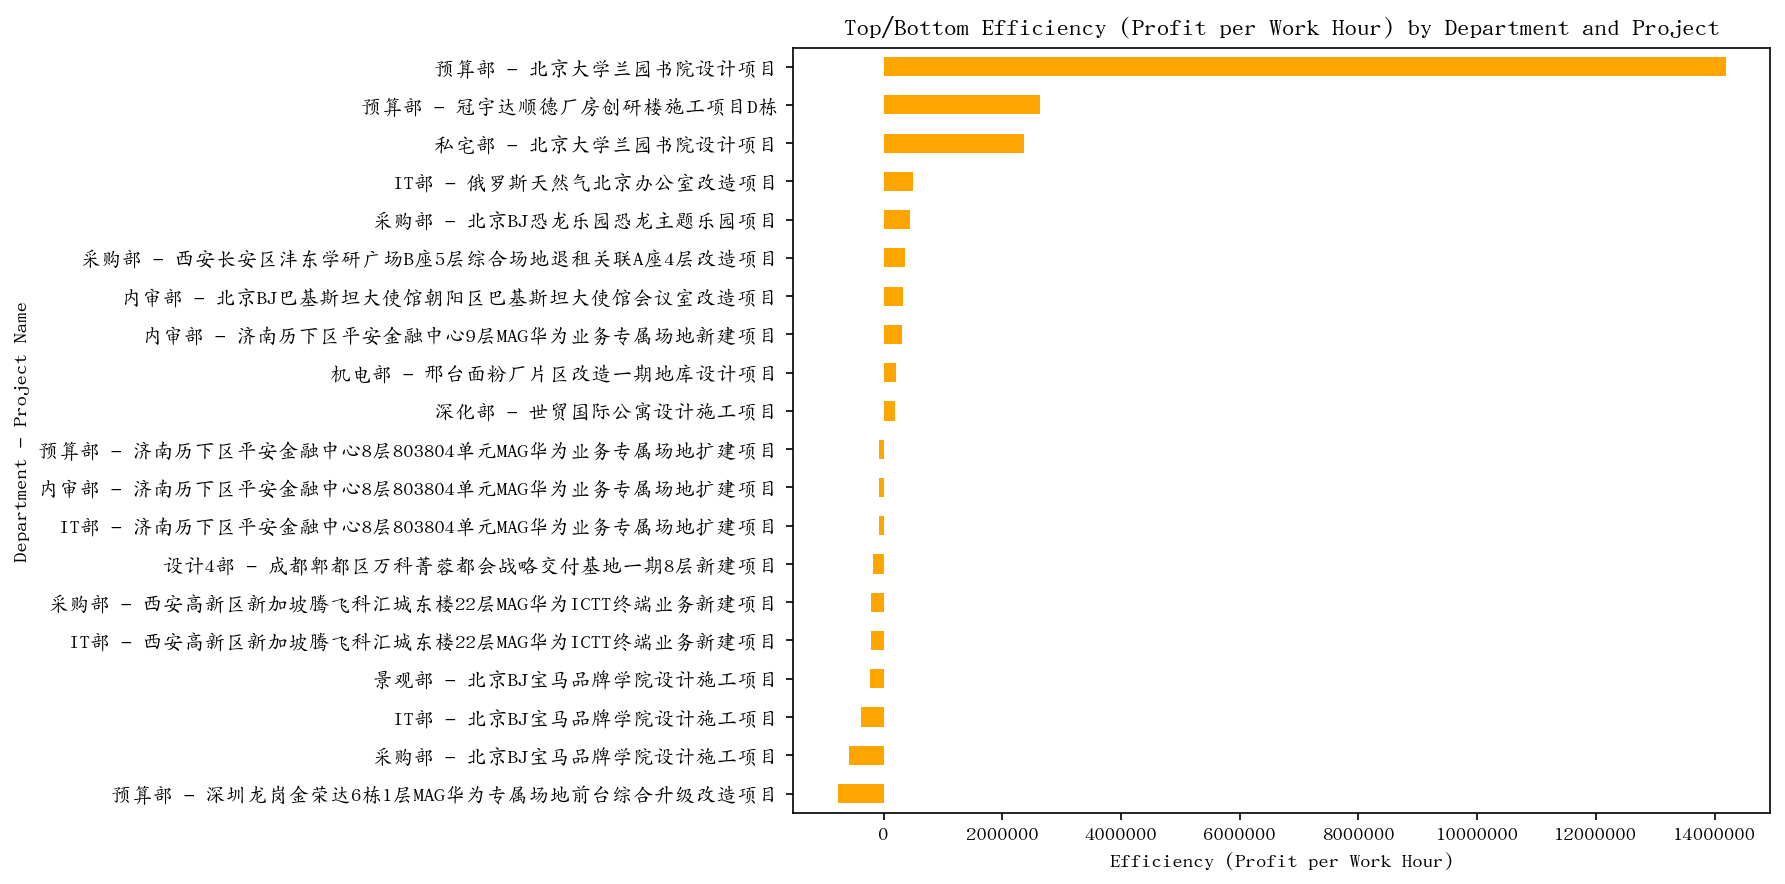

In [54]:
filtered_efficiency_df = sumed_df[['项目名称', 'profit_efficiency', '部门']]
filtered_efficiency_df = filtered_efficiency_df.groupby(['项目名称', '部门'])['profit_efficiency'].median().reset_index()
filtered_efficiency_df = filtered_efficiency_df.sort_values('profit_efficiency')

# Increase figure size and limit to top/bottom N projects (for example, the top n and bottom n by efficiency)
top_n = 10
filtered_efficiency_df = pd.concat([filtered_efficiency_df.head(top_n), filtered_efficiency_df.tail(top_n)])

# Plot Efficiency by Project (bar plot)
plt.figure(figsize=(12, 6), dpi=150)
filtered_efficiency_df['部门_项目名称'] = filtered_efficiency_df['部门'] + ' - ' + filtered_efficiency_df['项目名称']
filtered_efficiency_df.set_index('部门_项目名称')['profit_efficiency'].plot(kind='barh', color='orange')

# Replace the x-axis labels with the actual efficiency values
# x_ticks = plt.gca().get_xticks()  # Get current x-ticks (log-transformed values)
# x_labels = np.expm1(x_ticks) + min_eff  # Apply inverse of log1p to get original efficiency values
# plt.gca().set_xticklabels([f'{x:,.2f}' for x in x_labels])  # Set new x-tick labels with formatting
# plt.xlim(5, None)

# Format the x-axis to remove scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

# Set title and labels
plt.title('Top/Bottom Efficiency (Profit per Work Hour) by Department and Project')
plt.xlabel('Efficiency (Profit per Work Hour)')
plt.ylabel('Department - Project Name')

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Profit Efficiency by Department and Project.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

**Several visualizations for gs specific info - 谈判状态**

In [55]:
gs['盈利（元）']

0      506636.70
1      891938.15
2         404.53
3      278000.00
4      553987.96
         ...    
115      3155.11
116    227093.00
117     63810.74
118     23028.74
119    372983.32
Name: 盈利（元）, Length: 120, dtype: float64

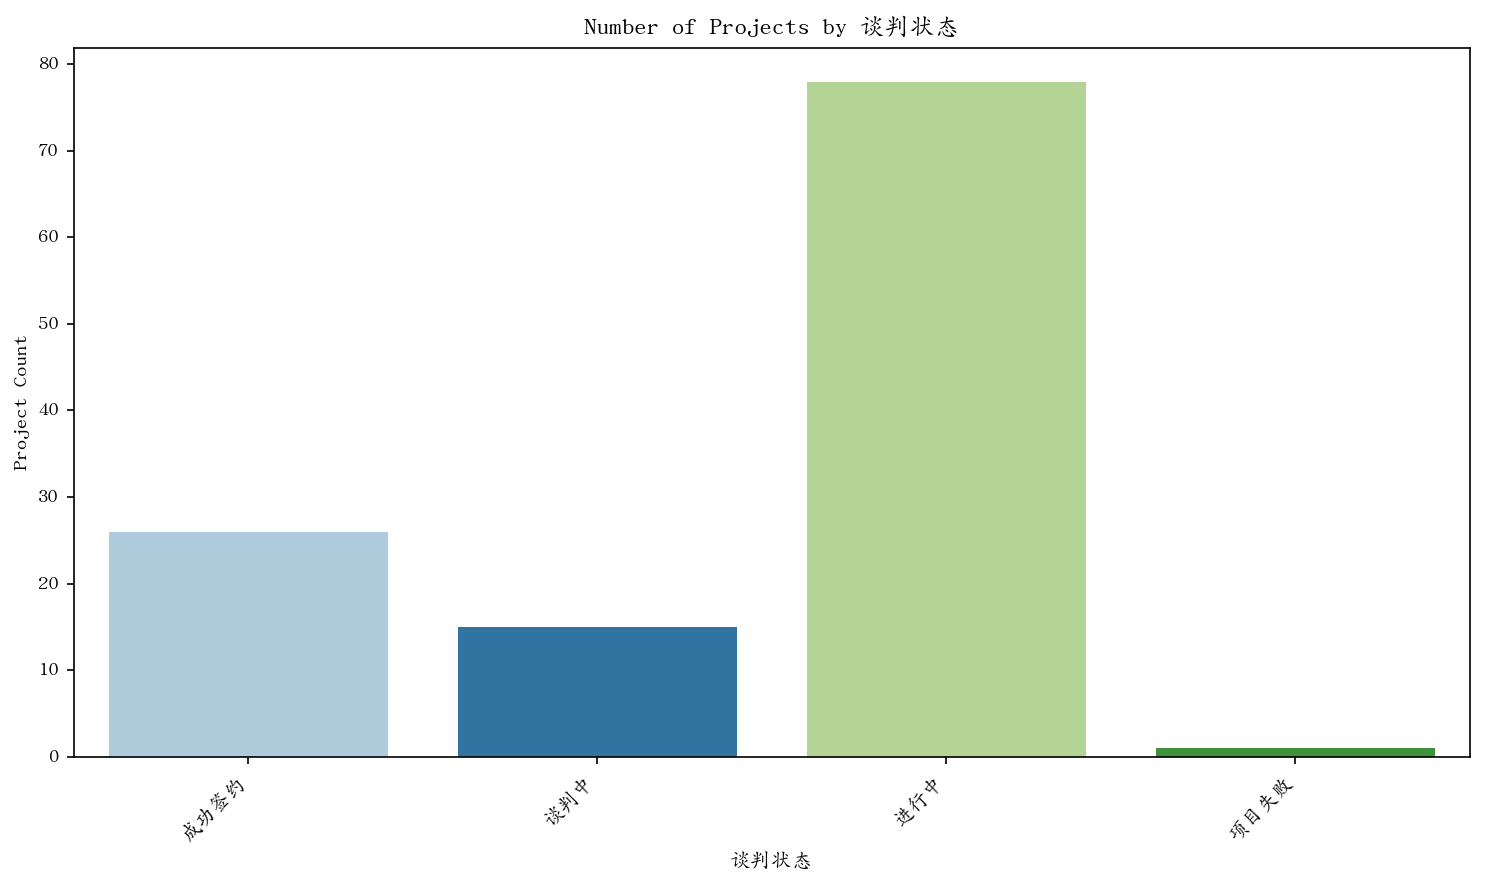

In [56]:
# Group by '谈判状态' and calculate required aggregations
clean_money_columns(gs, ['盈利（元）'])
gs_grouped = gs.groupby('谈判状态').agg(
    project_count=('项目名称', 'count'),
    avg_profit=('盈利（元）', 'sum')
).reset_index()

# Plot 1: Number of projects by 谈判状态
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(x='谈判状态', y='project_count', data=gs_grouped, palette='Paired')
plt.title('Number of Projects by 谈判状态')
plt.xlabel('谈判状态')
plt.ylabel('Project Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Number of Projects by 谈判状态.png', dpi=300, bbox_inches='tight')
plt.show()

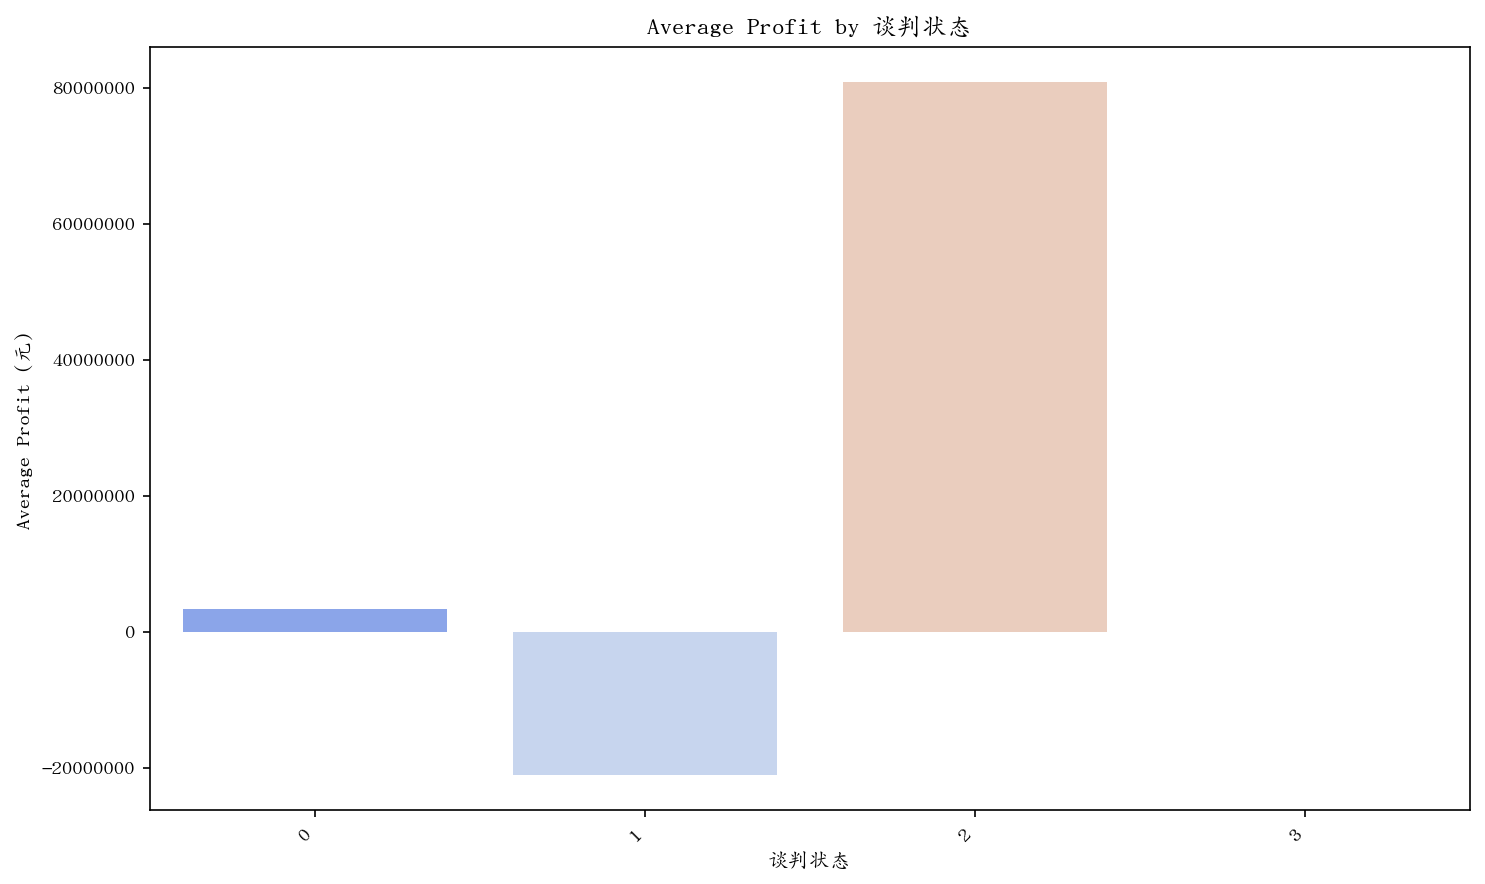

In [57]:
# Plot 2: Average Profit by 谈判状态 with colored bars
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(x='谈判状态', y='avg_profit', data=gs_grouped, palette='coolwarm')
plt.title('Average Profit by 谈判状态')
plt.xlabel('谈判状态')
plt.ylabel('Average Profit (元)')
plt.xticks(rotation=45, ha='right')

# Format the x-axis to remove scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation

plt.tight_layout()
plt.savefig('Average Profit by 谈判状态.png', dpi=300, bbox_inches='tight')
plt.show()

**Consider classify projects into small, medium, large. And do comparison of depts efficiency among each project size.**

In [58]:
# Prepare the data for clustering (use work hours and revenue)
X = sumed_df[['total_work_hours', 'revenue']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

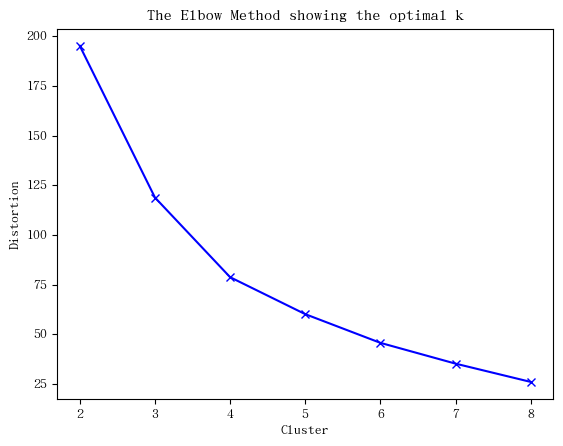

In [59]:
distortions = []
K = range(2,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeanModel.fit(X_scaled)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('Cluster')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [60]:
def k_means_silhouette(df):
    df_copy = df.copy()
    k_values = [2, 3, 4, 5, 6, 7, 8]
    kmeans = [KMeans(n_clusters=k_value, n_init = 10, random_state=42) for k_value in k_values]
    silhouette_scores = [silhouette_score(df_copy, each_kmeans.fit(df_copy).labels_) for each_kmeans in kmeans]
    print(kmeans)
    print(silhouette_scores)
    return max(silhouette_scores)
k_means_silhouette(X_scaled)

[KMeans(n_clusters=2, n_init=10, random_state=42), KMeans(n_clusters=3, n_init=10, random_state=42), KMeans(n_clusters=4, n_init=10, random_state=42), KMeans(n_clusters=5, n_init=10, random_state=42), KMeans(n_clusters=6, n_init=10, random_state=42), KMeans(n_clusters=7, n_init=10, random_state=42), KMeans(n_init=10, random_state=42)]
[0.8001016438116574, 0.7785028258531428, 0.7470822328512478, 0.7207502771649403, 0.7313292294442542, 0.7322010951062365, 0.6543009824816485]


0.8001016438116574

Cluster centers (unscaled): [[3.19187500e+02 1.64756712e+07]
 [1.53393939e+01 9.89619419e+05]
 [6.76000000e+01 2.02872325e+07]]


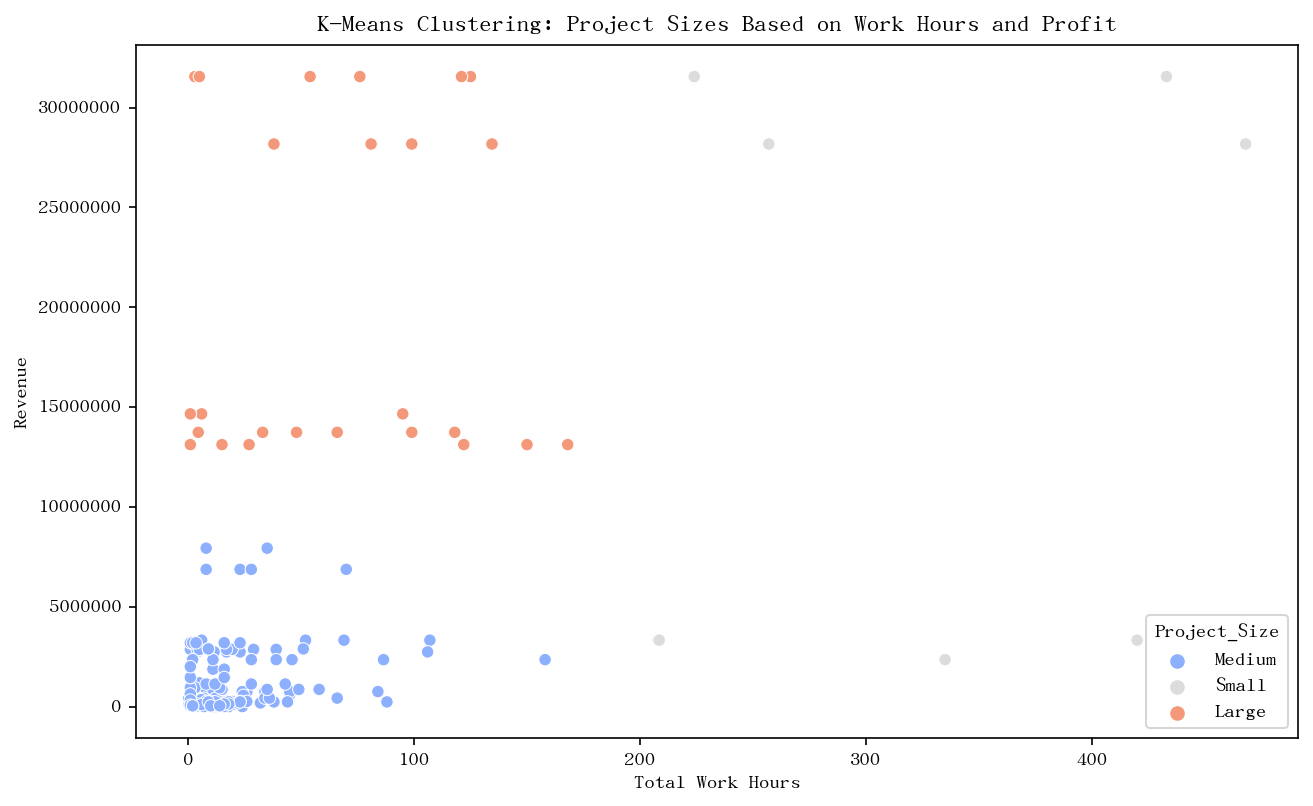

In [61]:
# From above evaluation, best k is 3, and it also represent small, medium, and large project
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=42)
sumed_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Check the cluster centers (this will help you understand which cluster is small/medium/large)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centers (unscaled):", cluster_centers)

sumed_df['Project_Size'] = sumed_df['Cluster'].map({0: 'Small', 1: 'Medium', 2: 'Large'})

# Plot the clusters if necessary
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(x='total_work_hours', y='revenue', hue='Project_Size', data=sumed_df, palette='coolwarm')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
plt.title('K-Means Clustering: Project Sizes Based on Work Hours and Profit')
plt.xlabel('Total Work Hours')
plt.ylabel('Revenue')
plt.savefig('Project Classification.png', dpi=300, bbox_inches='tight')
plt.show()

**Now, let's wrap things up**

In [62]:
sumed_df.to_csv('calculated.csv', index=False, encoding='utf-8-sig')

/tmp/ipykernel_78/855379856.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


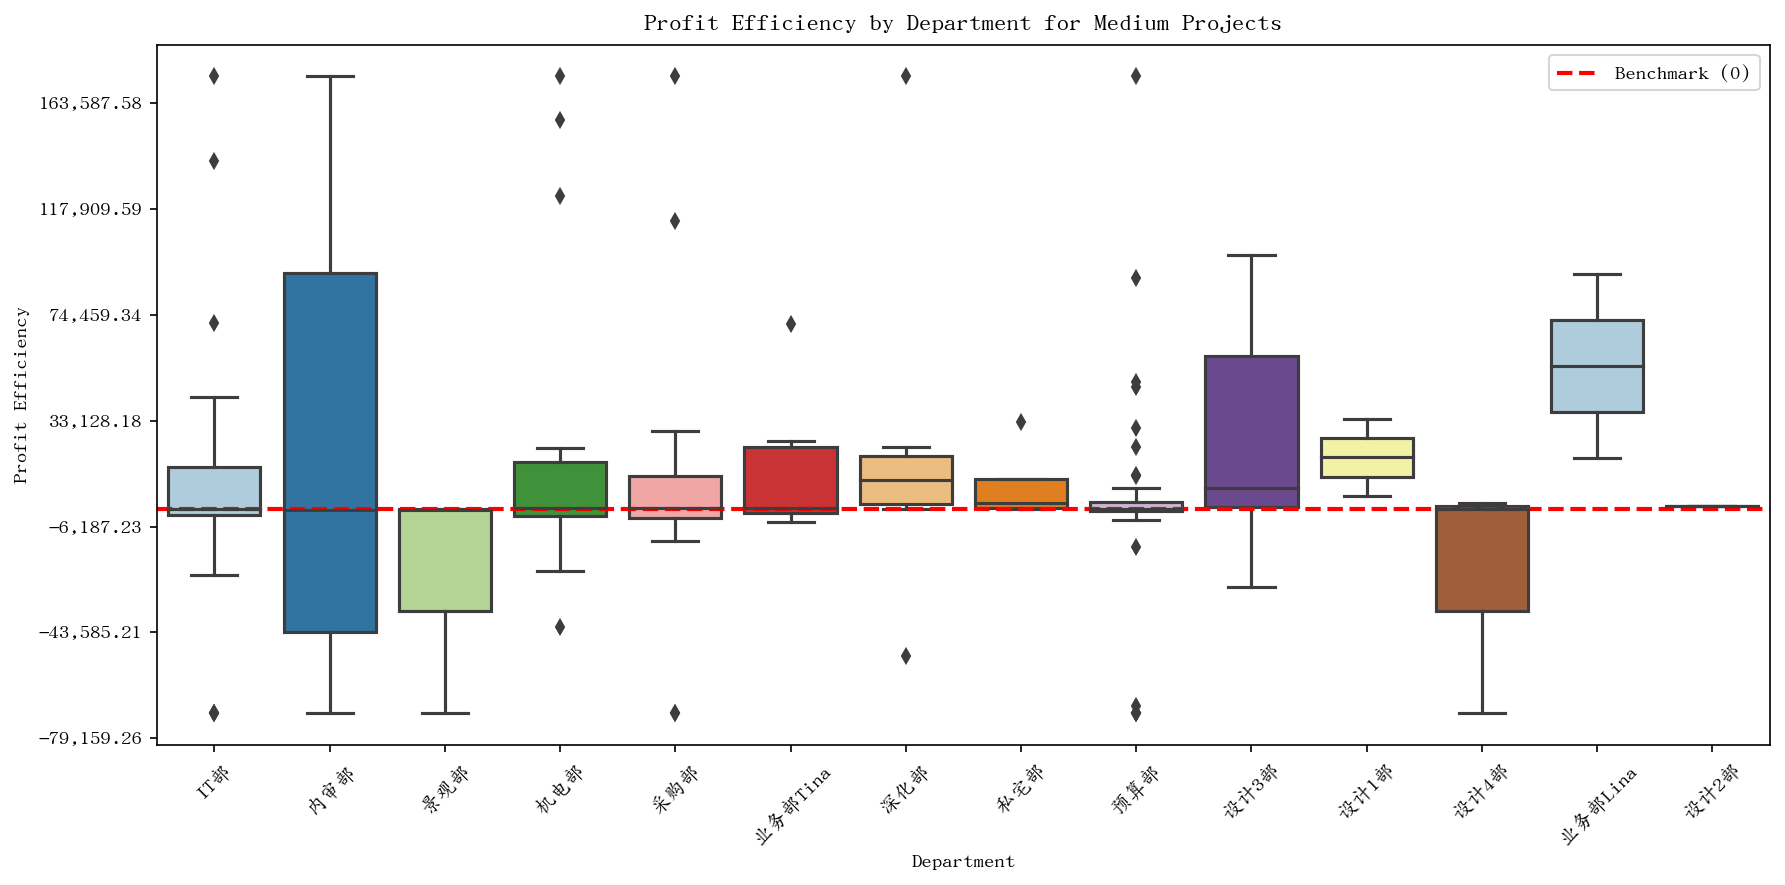

/tmp/ipykernel_78/855379856.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


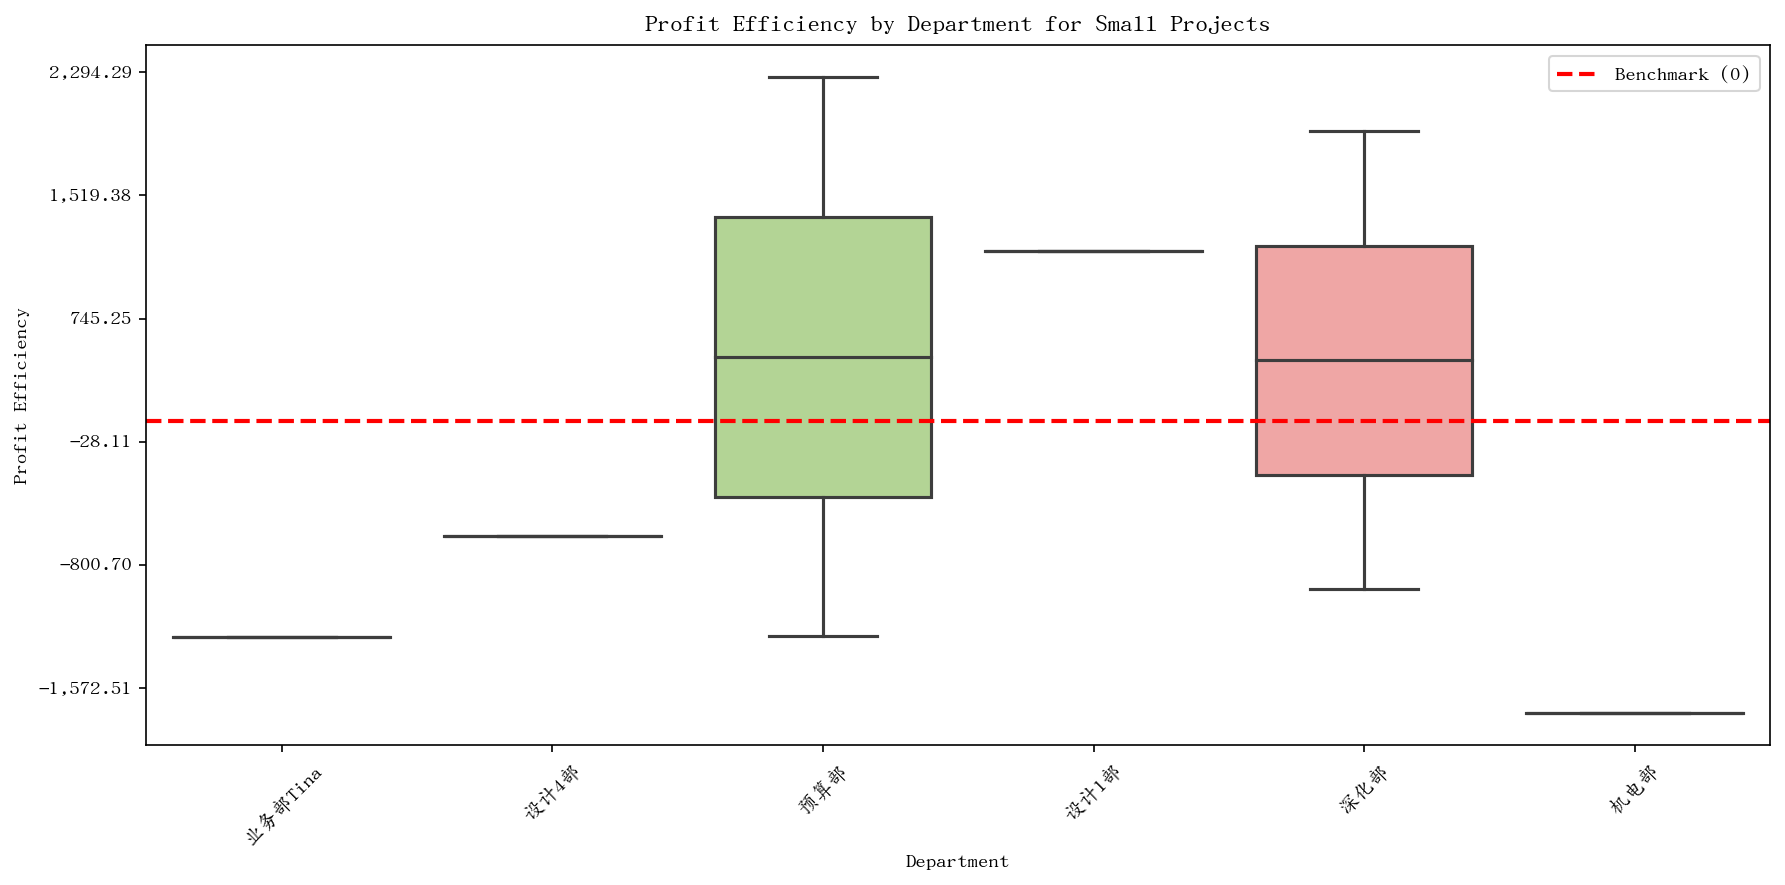

/tmp/ipykernel_78/855379856.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])


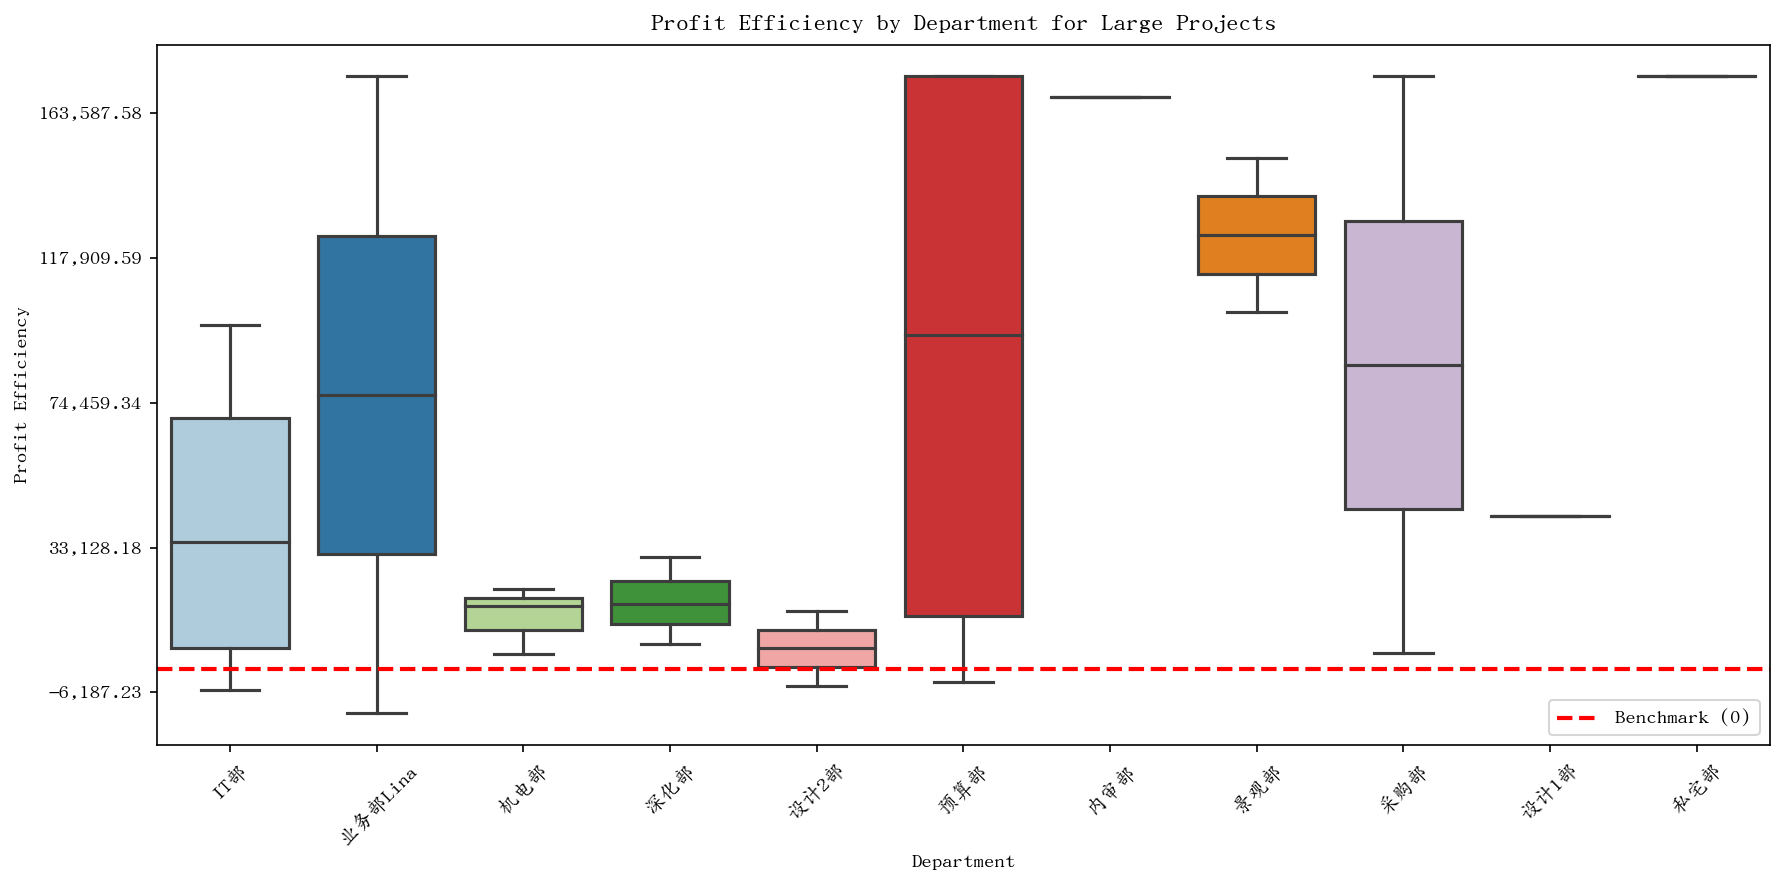

In [63]:
for size in sumed_df['Project_Size'].unique():
    subset = sumed_df[sumed_df['Project_Size'] == size]  # Filter data for the current project size
    
    if len(subset) > 5:
        plt.figure(figsize=(12, 6), dpi=150)
        sns.boxplot(x='部门', y='winsorized_logged_rescaled_profit_efficiency', data=subset, palette='Paired')
        # Add a horizontal line at the benchmark of 100 (log-transformed)
        benchmark_value = np.log1p(100 - min_eff)  # Apply the log1p transformation to 100
        plt.axhline(y=benchmark_value, color='red', linestyle='--', label='Benchmark (0)', linewidth=2)
        plt.legend()
        
        # Adjust the y-axis labels to show the original efficiency values (inverse log transformation)
        y_ticks = plt.gca().get_yticks()
        y_labels = np.expm1(y_ticks) + min_eff  # Apply inverse of log1p to get original efficiency values
        plt.gca().set_yticklabels([f'{y:,.2f}' for y in y_labels])
        
        # Add title and labels
        plt.xlabel('Department')
        plt.xticks(rotation=45)
        plt.ylabel('Profit Efficiency')
        plt.title(f'Profit Efficiency by Department for {size} Projects')
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.savefig(f'Profit Efficiency by Department for {size} Projects.png', dpi=300, bbox_inches='tight')   
        # Show plot
        plt.show()

    else:
        subset = subset.groupby('部门').agg({
            'winsorized_logged_rescaled_profit_efficiency': 'median',
            'profit_efficiency': 'median'  # Calculate the median for profit efficiency as well
        }).reset_index()
    
        # Use profit_efficiency to color the bars (coolwarm palette, warm for high, cool for low)
        norm = plt.Normalize(subset['profit_efficiency'].min(), subset['profit_efficiency'].max())
        cmap = sns.diverging_palette(240, 10, as_cmap=True)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
    
        # Create a horizontal bar chart and color by profit_efficiency
        bar_colors = sm.to_rgba(subset['profit_efficiency'])
    
        plt.figure(figsize=(len(subset)*2, 3), dpi=170)
        bar_plot = sns.barplot(x='profit_efficiency', y='部门', data=subset, palette=bar_colors)
        
        # Add text to the bars to show the profit_efficiency values
        for i, profit_value in enumerate(subset['profit_efficiency']):
            bar_plot.text(profit_value, i, f'{profit_value:,.2f}', color='black', ha='center', va='center')
    
        plt.ylabel('Median Profit Efficiency')  
        plt.title(f'Median Profit Efficiency by Department for {size} Projects')
        plt.savefig(f'Median Profit Efficiency by Department for {size} Projects.png', dpi=300, bbox_inches='tight')       
        # Show the plot
        plt.tight_layout()
        plt.show()

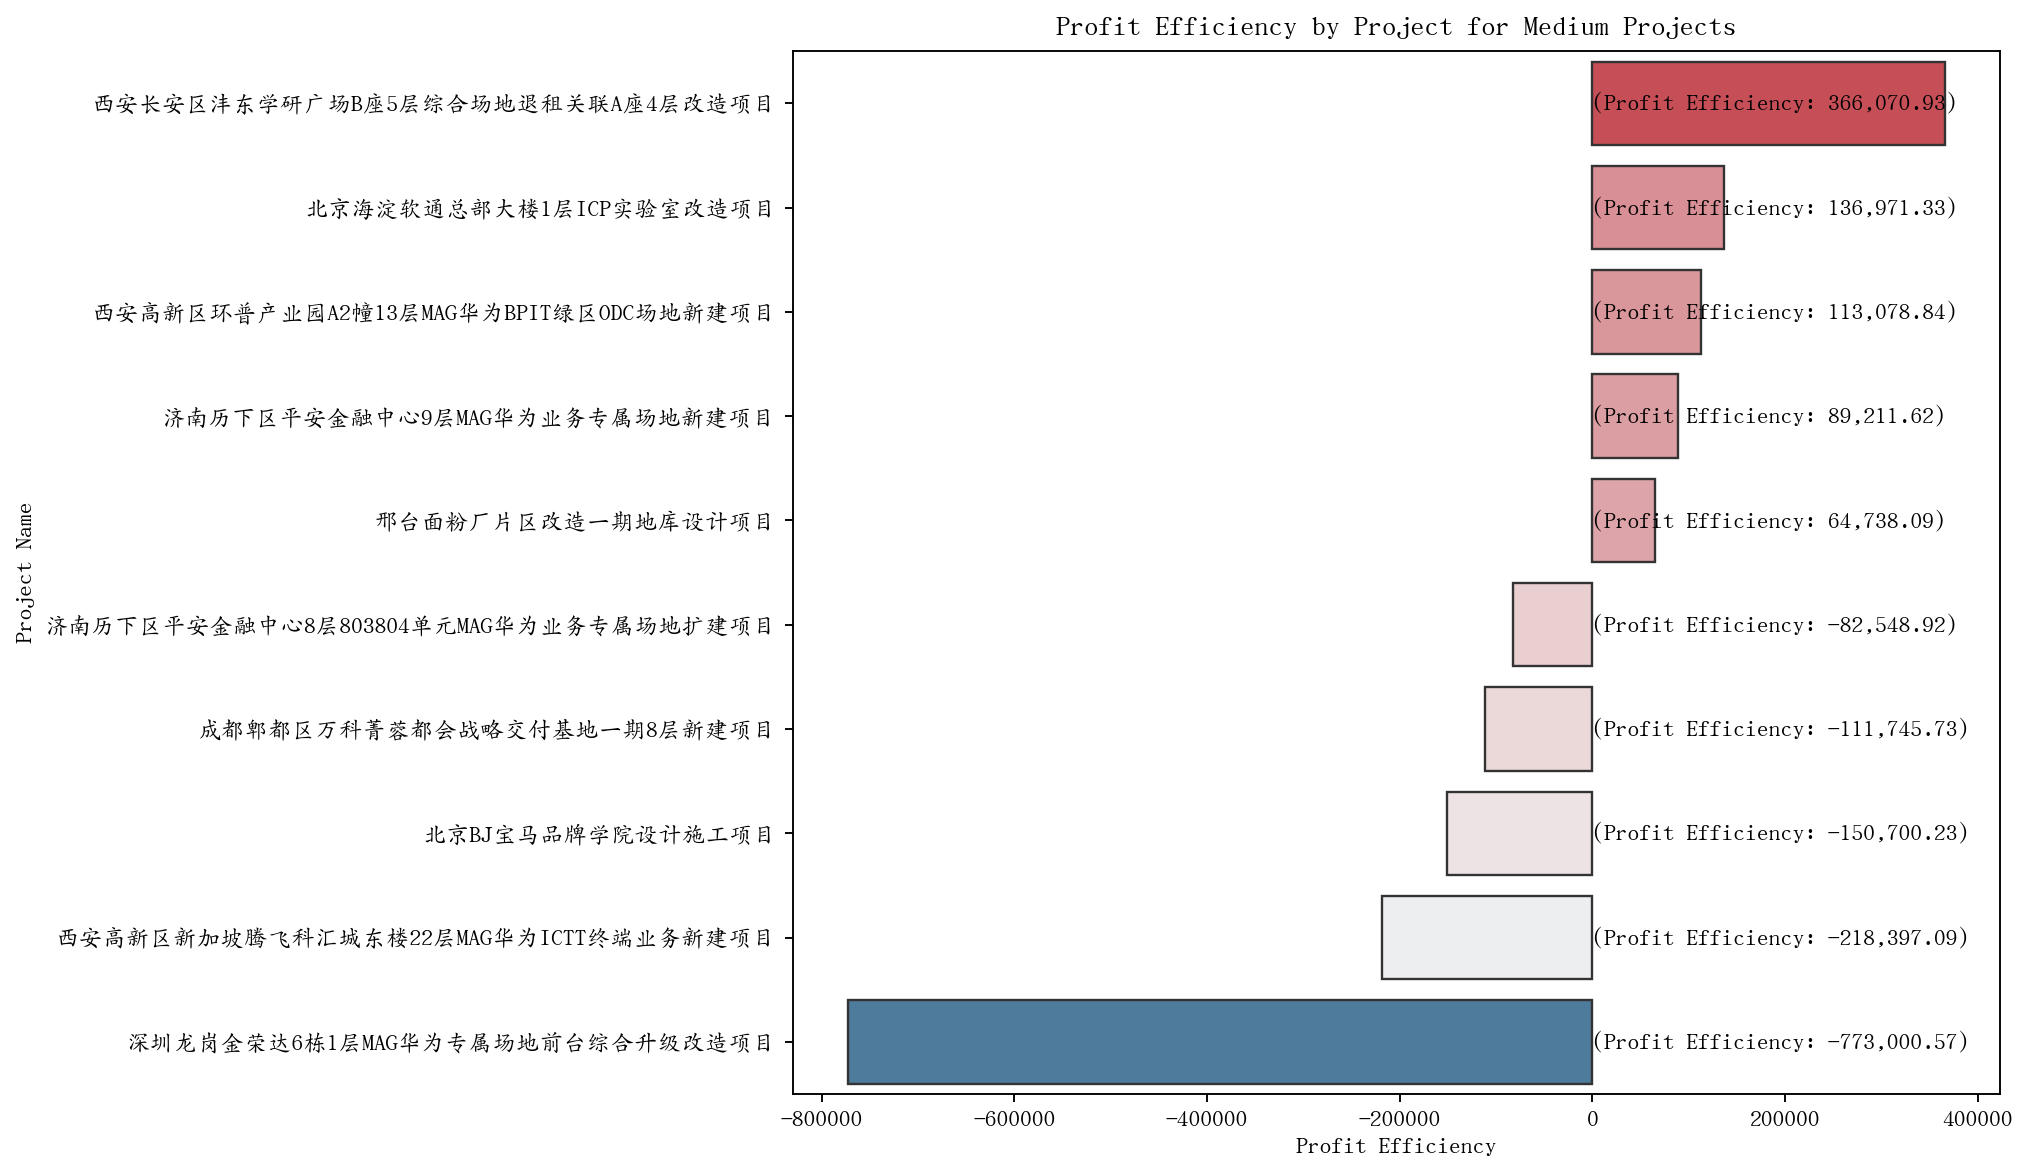

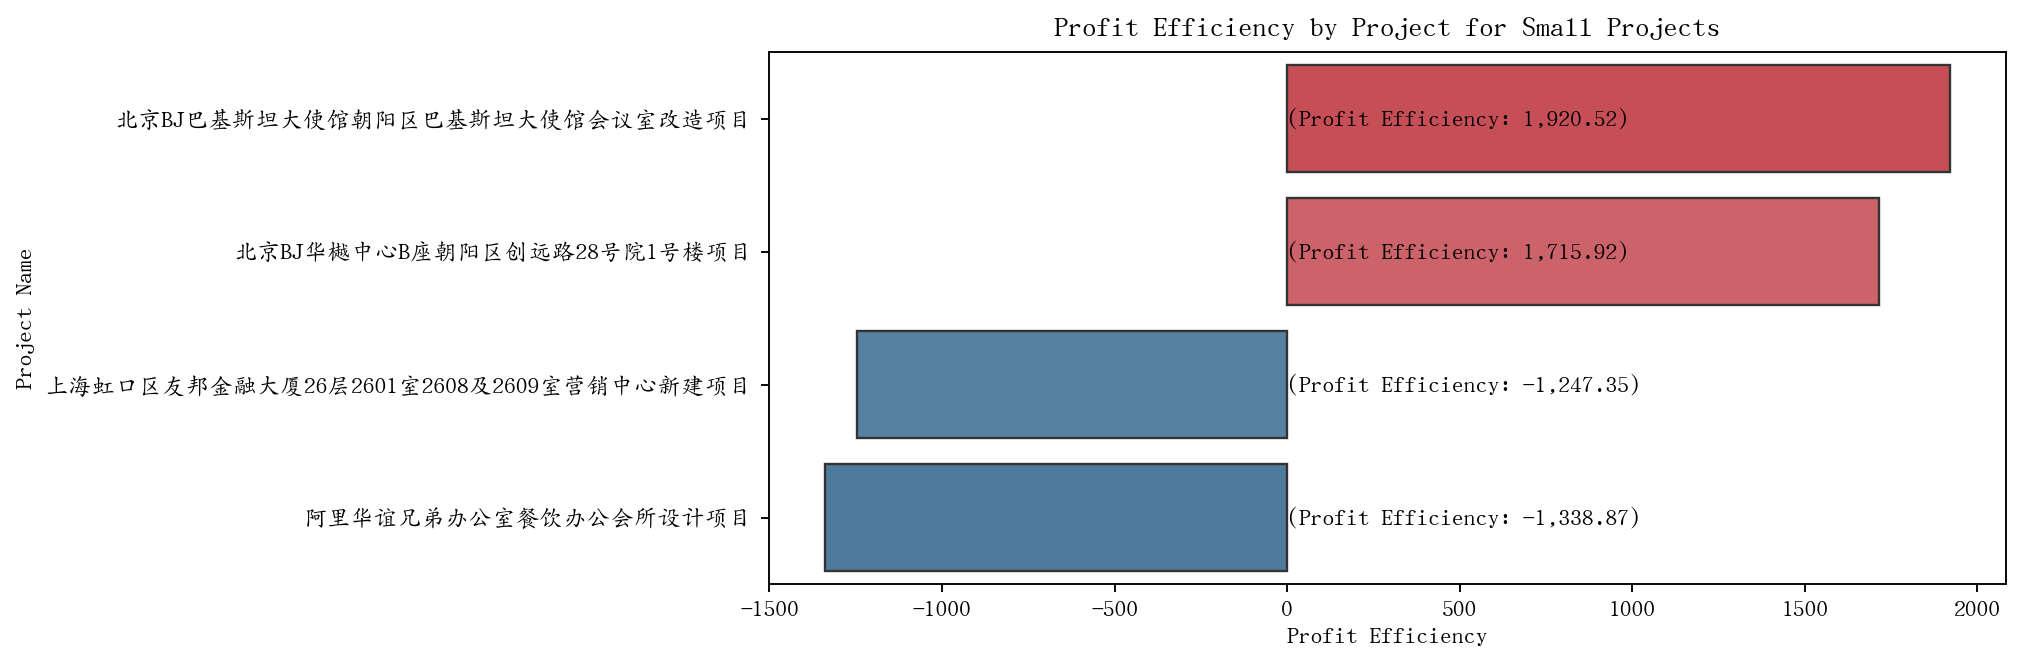

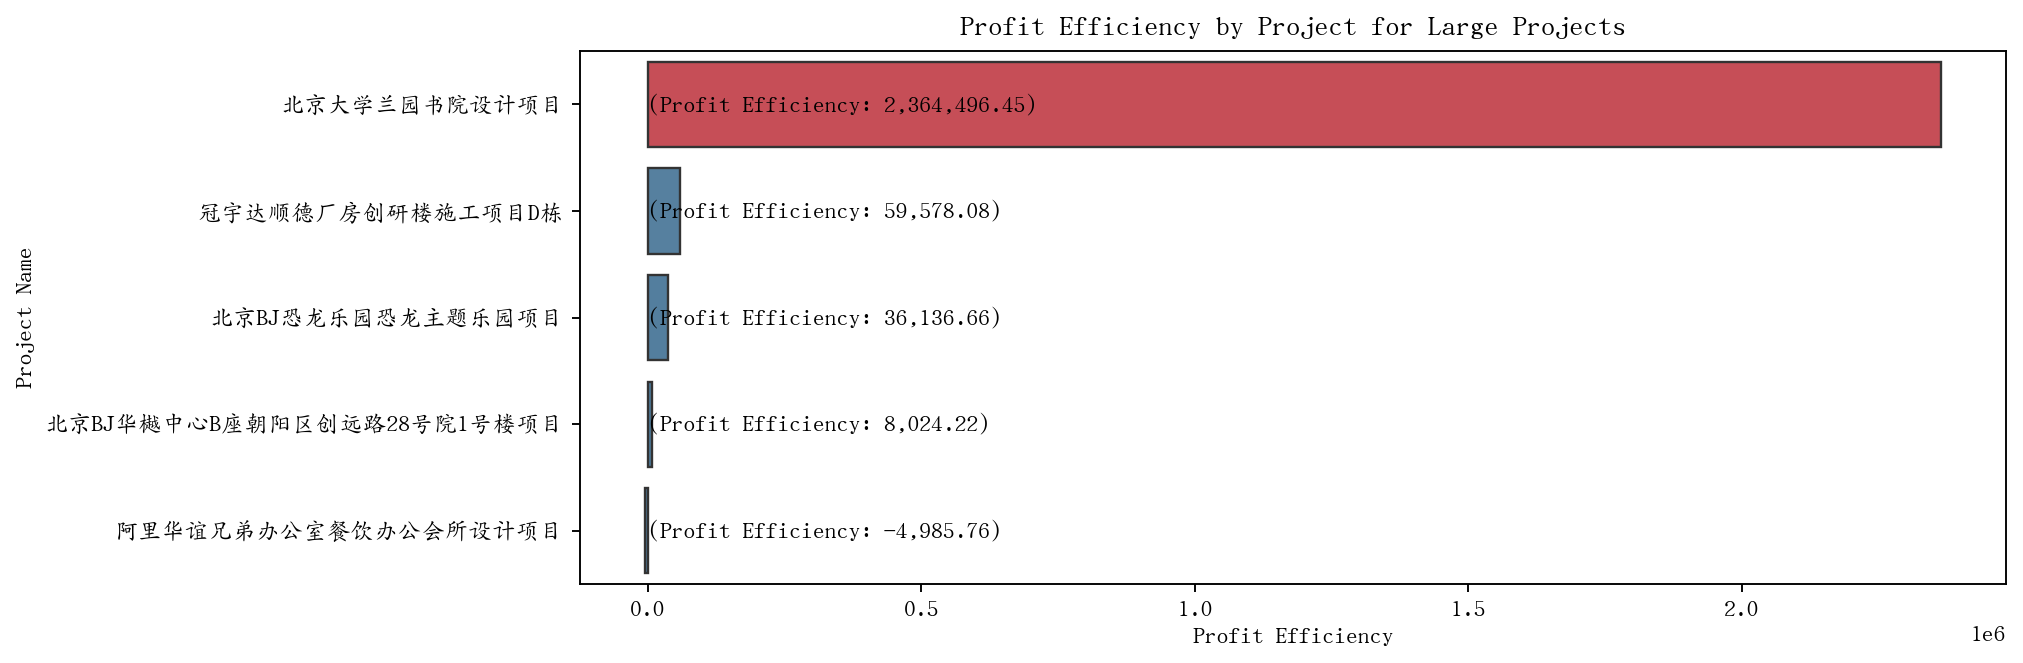

In [64]:
for size in sumed_df['Project_Size'].unique():
    subset = sumed_df[sumed_df['Project_Size'] == size]  # Filter data for the current project size
    
    # Group by project name, calculating both the median profit efficiency and winsorized efficiency
    subset = subset.groupby('项目名称').agg({
        'winsorized_logged_rescaled_profit_efficiency': 'median',
        'profit_efficiency': 'median'  # Calculate the median for profit efficiency as well
    }).reset_index()

    num_rows = len(subset['项目名称'].unique())  # Number of unique projects

    # If the number of rows exceeds 20, show only the top 5 and bottom 5 by profit efficiency
    if num_rows > 20:
        top_bottom_n = 5
        # Sort by profit efficiency and select top and bottom 5 projects
        top_bottom_subset = pd.concat([subset.nlargest(top_bottom_n, 'profit_efficiency'),
                                       subset.nsmallest(top_bottom_n, 'profit_efficiency')])
        subset = top_bottom_subset  # Use only the top 5 and bottom 5

    # Sort subset by winsorized efficiency for a clear bar chart display
    subset = subset.sort_values('profit_efficiency', ascending=False)

    # Determine figure size dynamically based on number of rows
    num_rows = len(subset['项目名称'].unique())  # Update number of rows after filtering
    plt.figure(figsize=(12, max(4, num_rows * 0.7)), dpi=170)  # Adjust height based on number of rows

    # Use seaborn's built-in RdYlGn color palette
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    # Use profit_efficiency to color the bars (coolwarm palette, warm for high, cool for low)
    norm = plt.Normalize(subset['profit_efficiency'].min(), subset['profit_efficiency'].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a horizontal bar chart and color by profit_efficiency
    bar_colors = sm.to_rgba(subset['profit_efficiency'])
    # Create a horizontal bar chart with a color gradient for winsorized efficiency
    sns.barplot(
        x='profit_efficiency', 
        y='项目名称', 
        data=subset, 
        palette=bar_colors,  # Use a gradient from cool (low) to warm (high)
        edgecolor=".2"
    )

    # Add value labels to the bars for profit_efficiency only
    for i, profit_value in enumerate(subset['profit_efficiency']):
        plt.text(0, i, f'(Profit Efficiency: {profit_value:,.2f})', va='center', ha='left', color='black')  # Add profit_efficiency label

    # Add title and labels
    plt.title(f'Profit Efficiency by Project for {size} Projects')
    plt.xlabel('Profit Efficiency')
    plt.ylabel('Project Name')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.savefig(f'Profit Efficiency by Project for {size} Projects.png', dpi=300, bbox_inches='tight')   

    # Show plot
    plt.show()

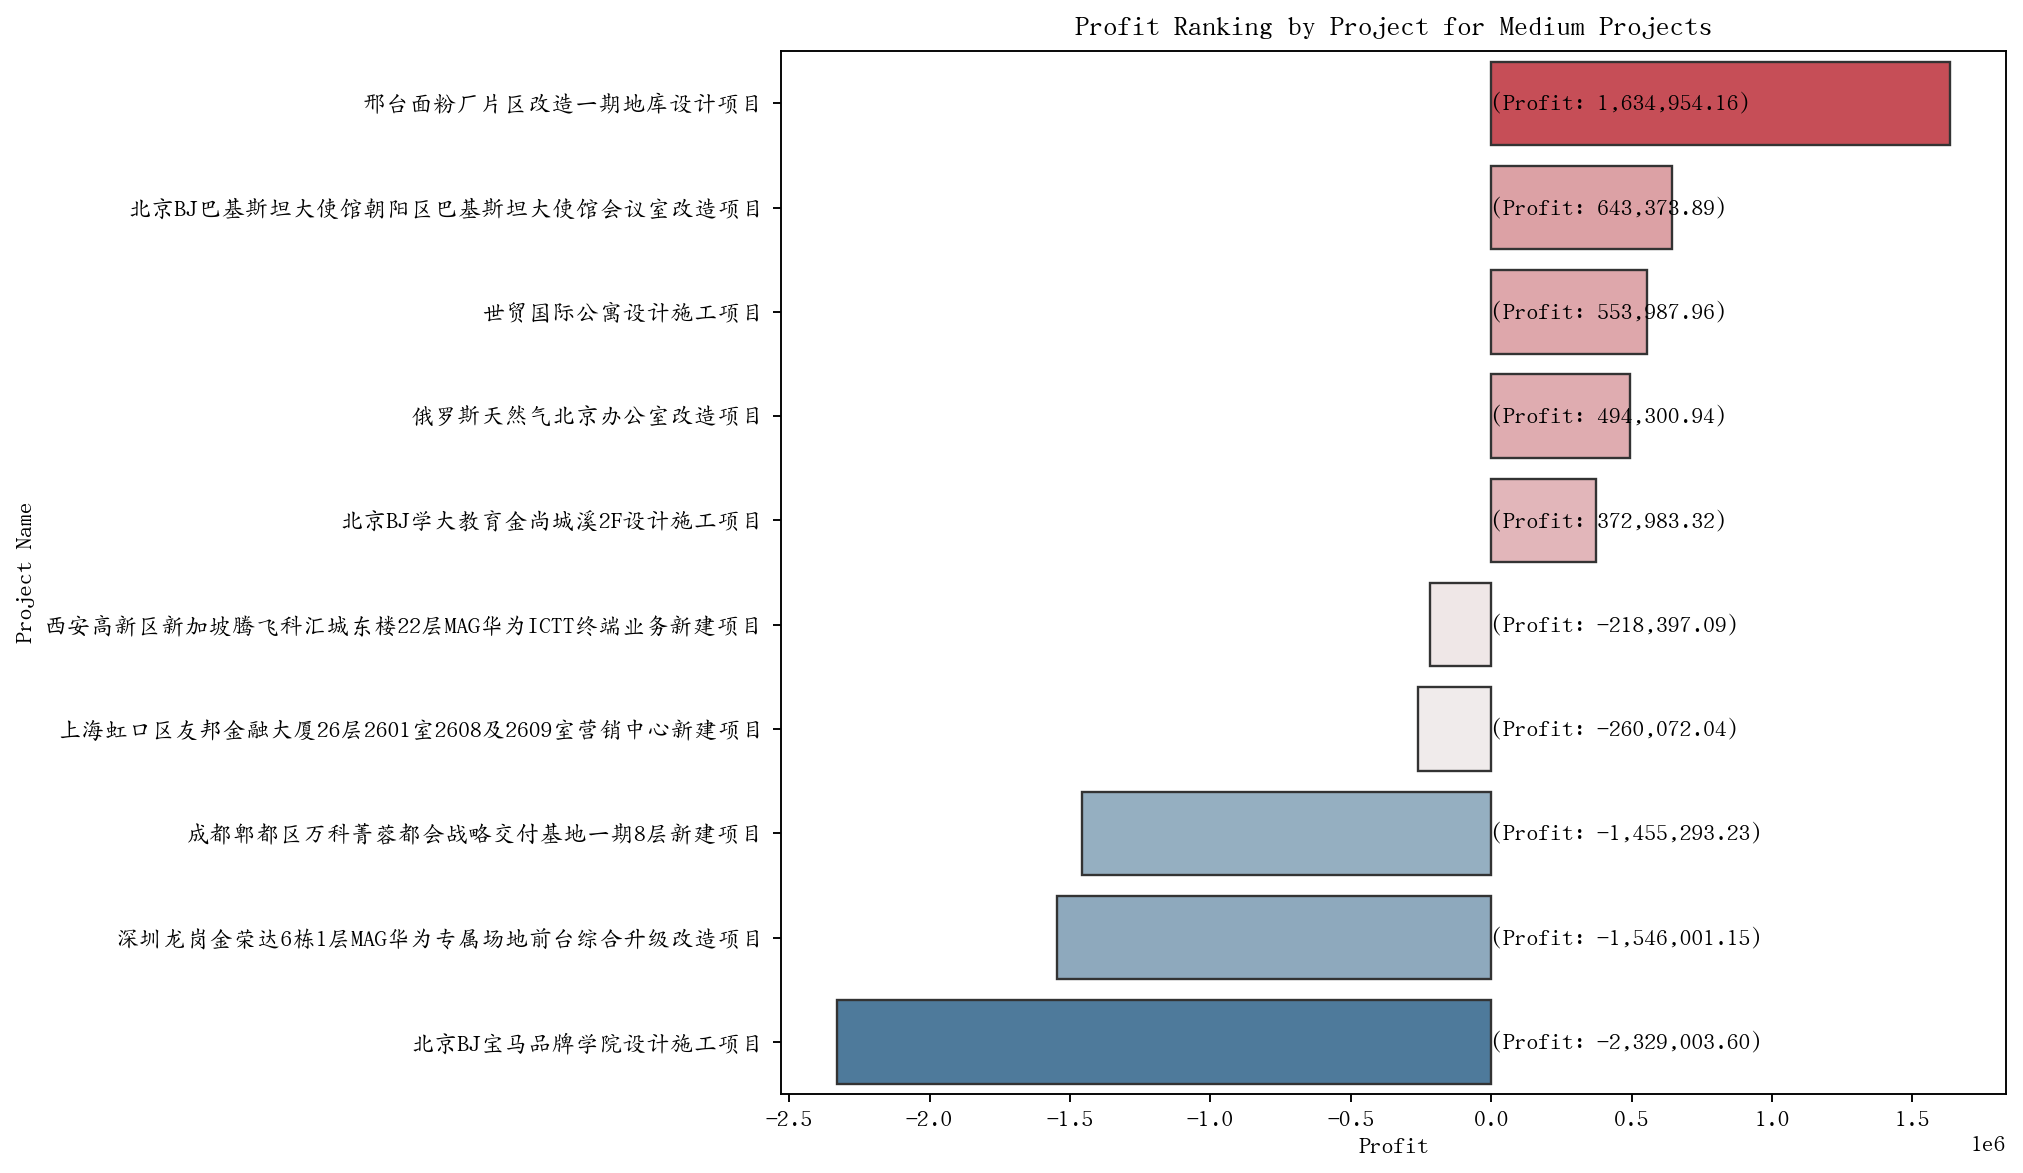

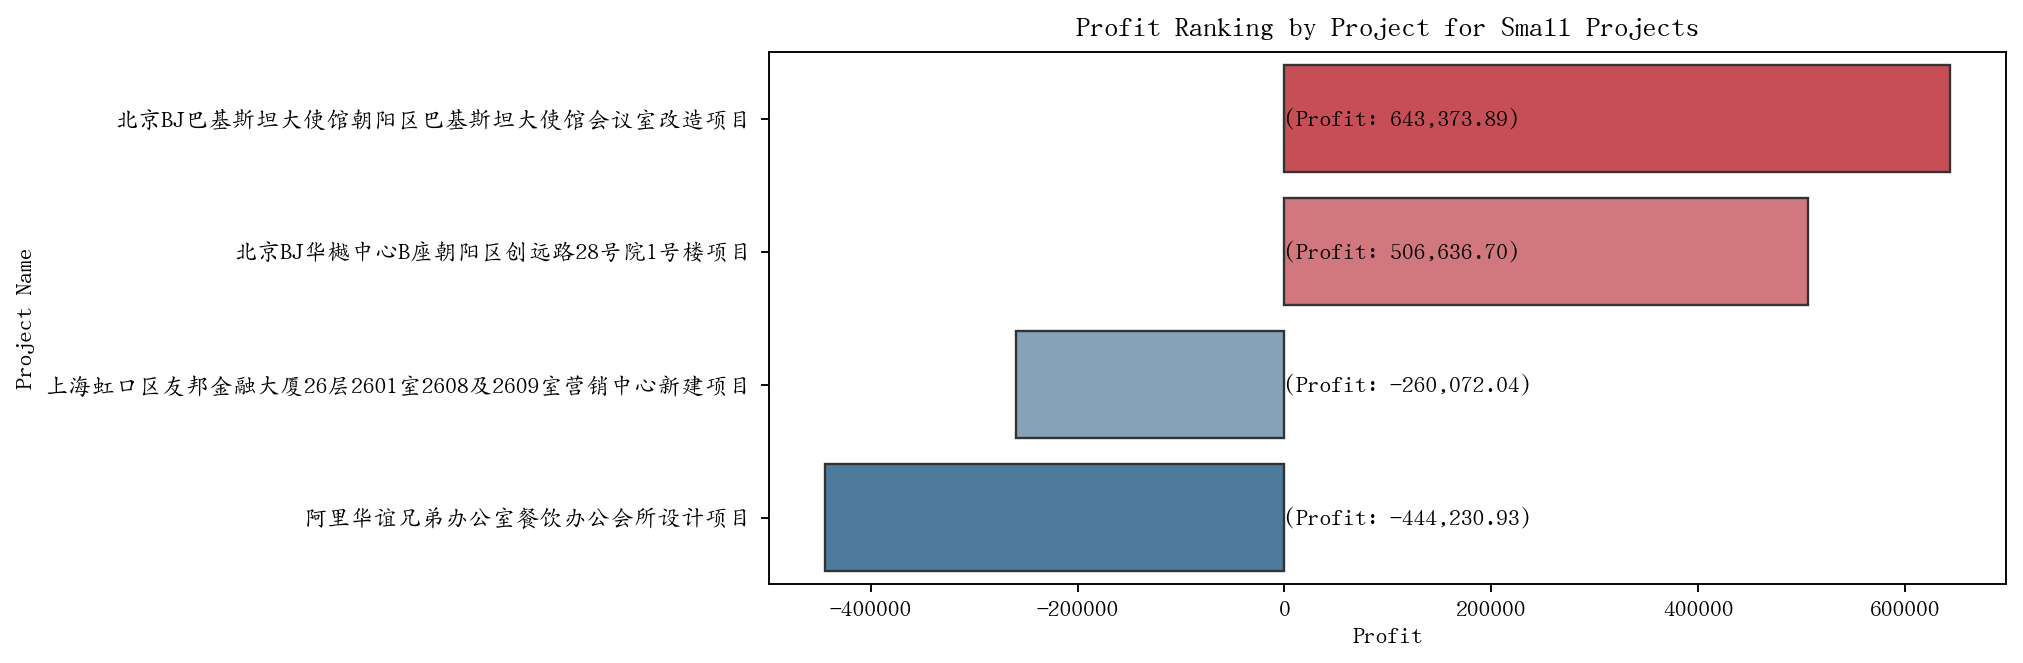

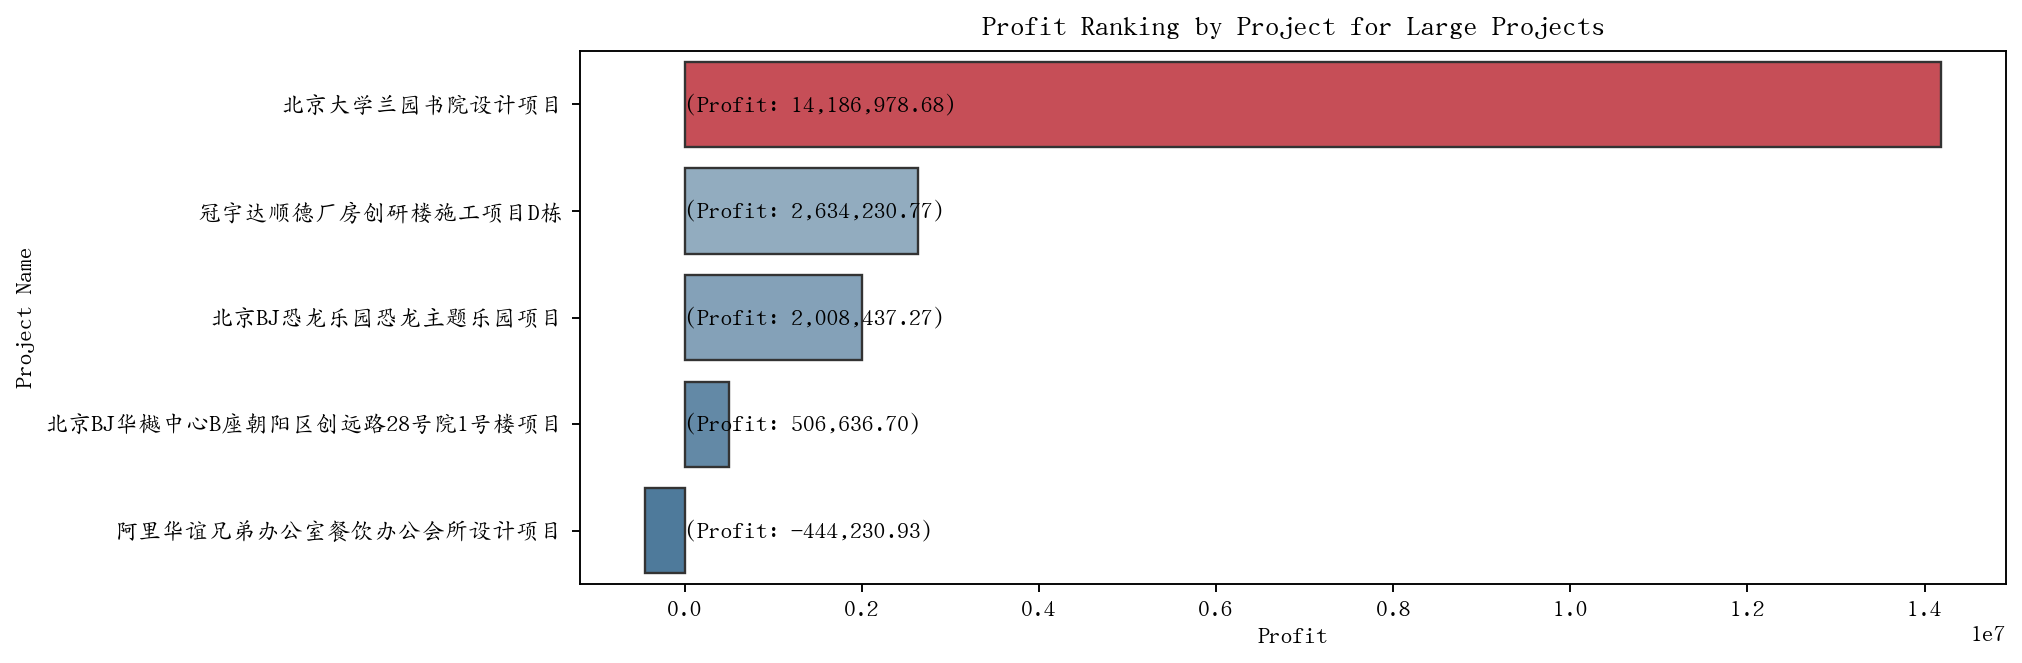

In [69]:
# Visualization profit by project size
for size in sumed_df['Project_Size'].unique():
    subset = sumed_df[sumed_df['Project_Size'] == size]  # Filter data for the current project size
    
    subset = subset.groupby('项目名称').agg({
        'profit': 'first'
    }).reset_index()

    num_rows = len(subset['项目名称'].unique())  # Number of unique projects

    # If the number of rows exceeds 20, show only the top 5 and bottom 5 by profit efficiency
    if num_rows > 20:
        top_bottom_n = 5
        # Sort by profit efficiency and select top and bottom 5 projects
        top_bottom_subset = pd.concat([subset.nlargest(top_bottom_n, 'profit'),
                                       subset.nsmallest(top_bottom_n, 'profit')])
        subset = top_bottom_subset  # Use only the top 5 and bottom 5

    # Sort subset by winsorized efficiency for a clear bar chart display
    subset = subset.sort_values('profit', ascending=False)

    # Determine figure size dynamically based on number of rows
    num_rows = len(subset['项目名称'].unique())  # Update number of rows after filtering
    plt.figure(figsize=(12, max(4, num_rows * 0.7)), dpi=170)  # Adjust height based on number of rows

    # Use seaborn's built-in RdYlGn color palette
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    # Use profit_efficiency to color the bars (coolwarm palette, warm for high, cool for low)
    norm = plt.Normalize(subset['profit'].min(), subset['profit'].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a horizontal bar chart and color by profit_efficiency
    bar_colors = sm.to_rgba(subset['profit'])
    # Create a horizontal bar chart with a color gradient for winsorized efficiency
    sns.barplot(
        x='profit', 
        y='项目名称', 
        data=subset, 
        palette=bar_colors,  # Use a gradient from cool (low) to warm (high)
        edgecolor=".2"
    )

    # Add value labels to the bars for profit_efficiency only
    for i, profit_value in enumerate(subset['profit']):
        plt.text(0, i, f'(Profit: {profit_value:,.2f})', va='center', ha='left', color='black')  # Add profit_efficiency label

    # Add title and labels
    plt.title(f'Profit Ranking by Project for {size} Projects')
    plt.xlabel('Profit')
    plt.ylabel('Project Name')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.savefig(f'Profit Ranking by Project for {size} Projects.png', dpi=300, bbox_inches='tight')   

    # Show plot
    plt.show()

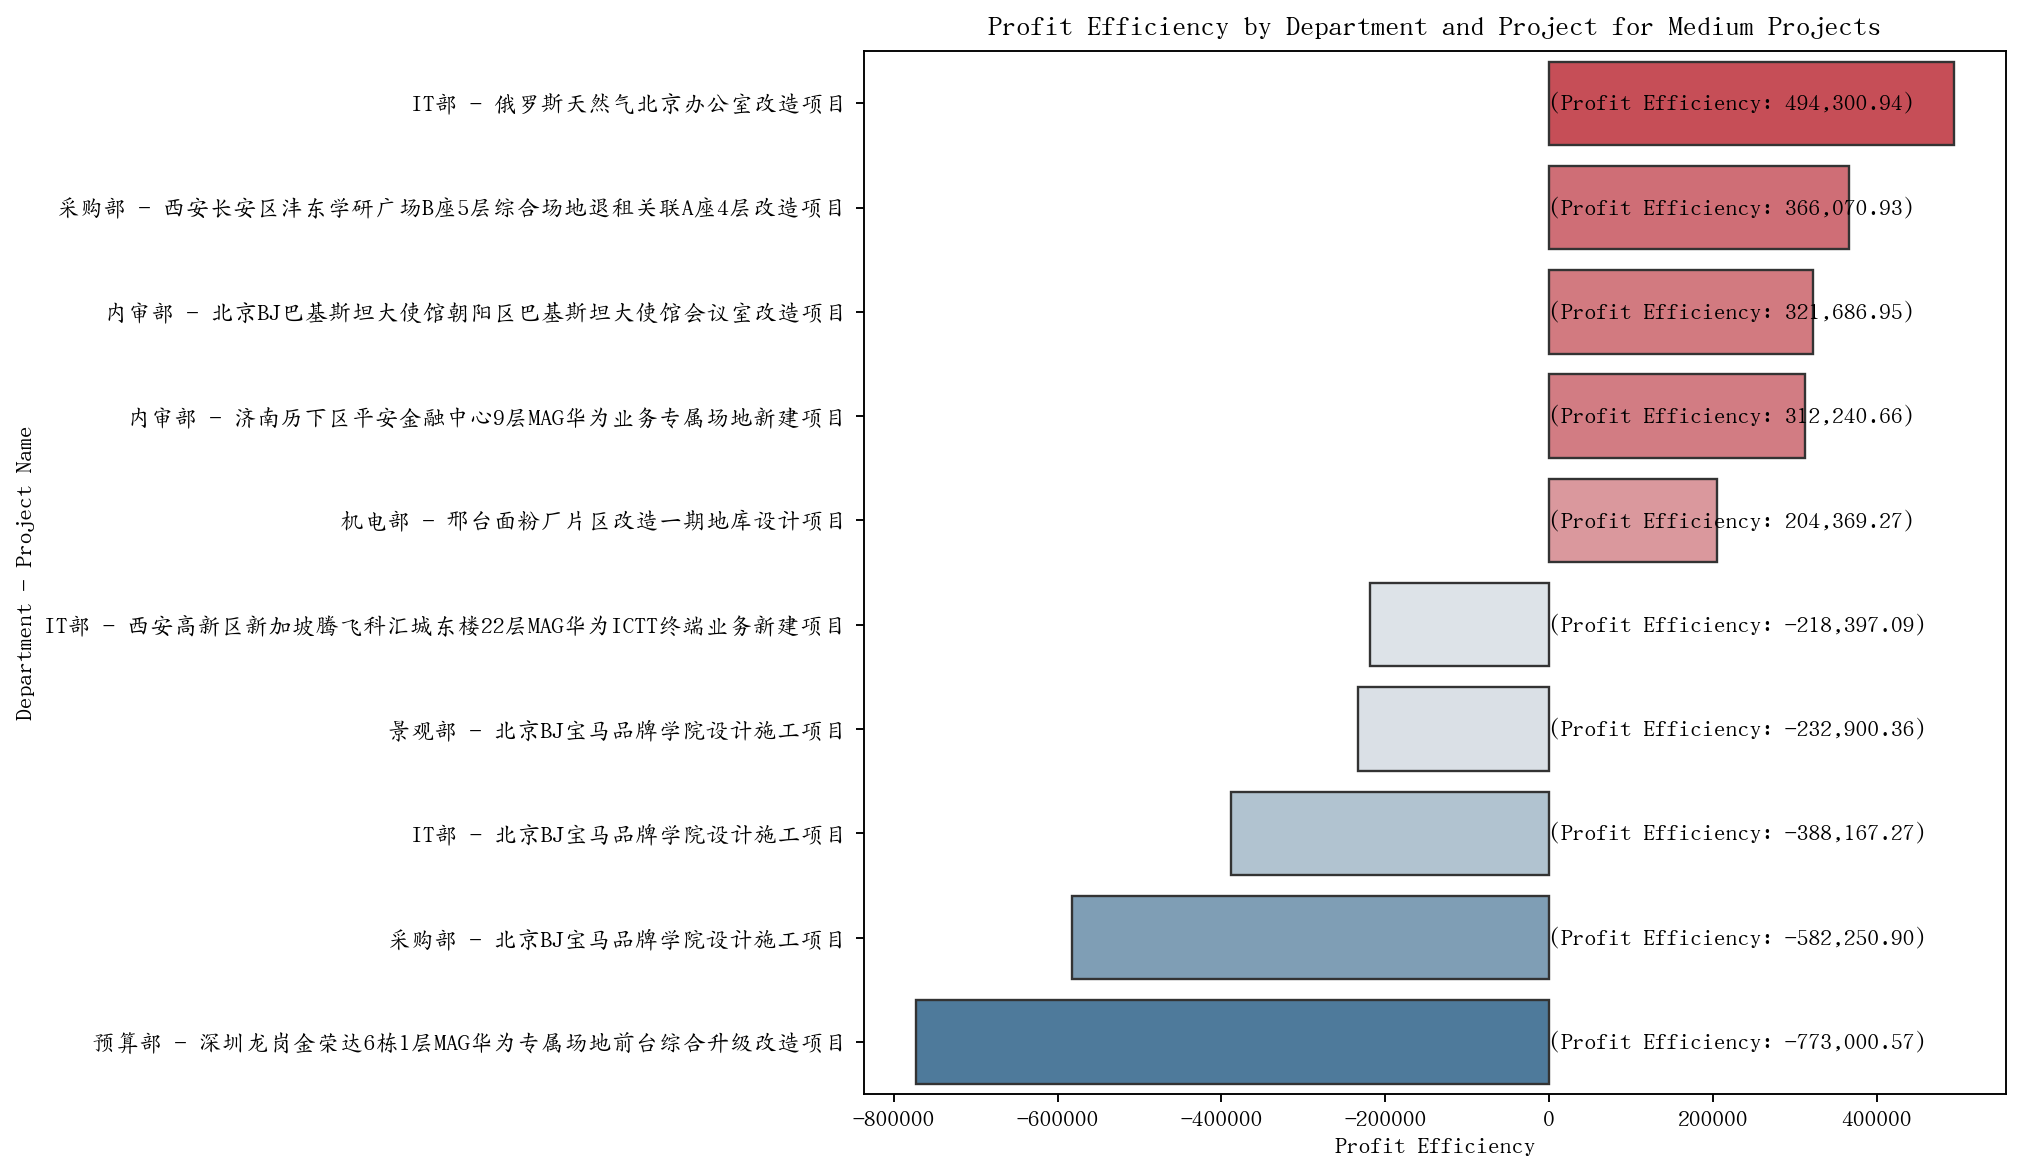

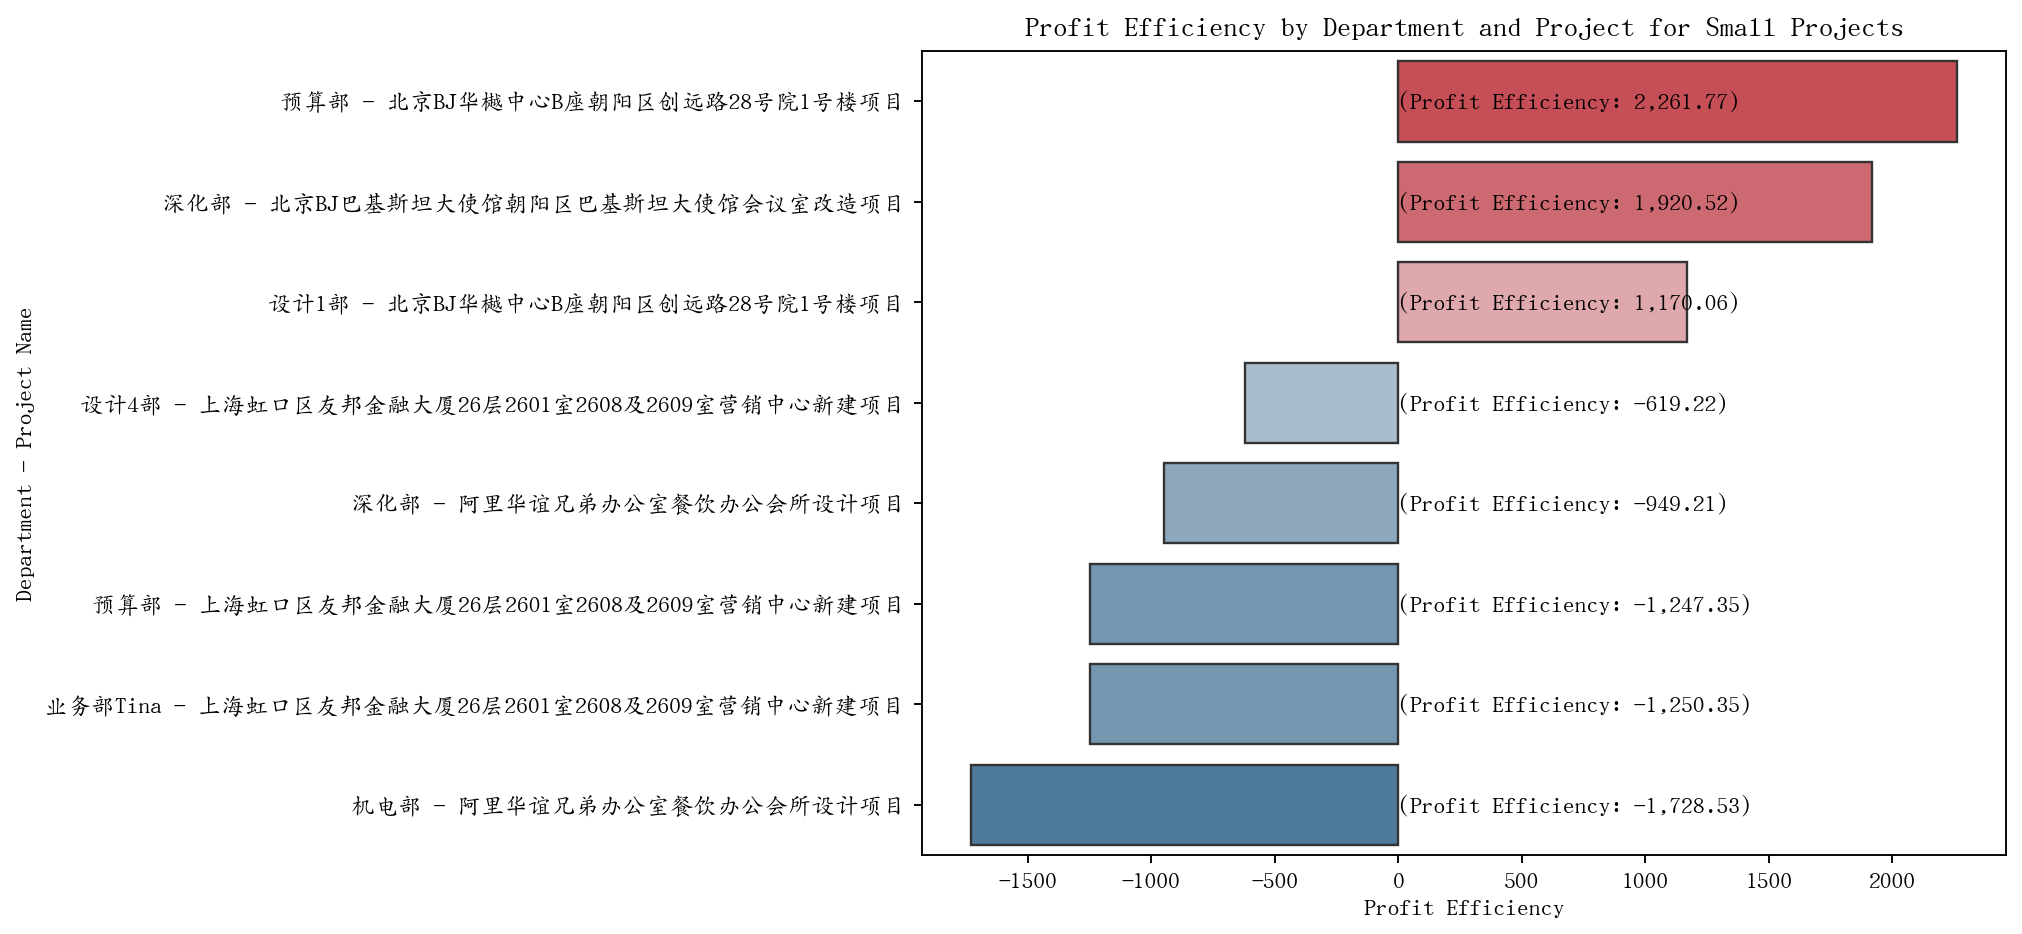

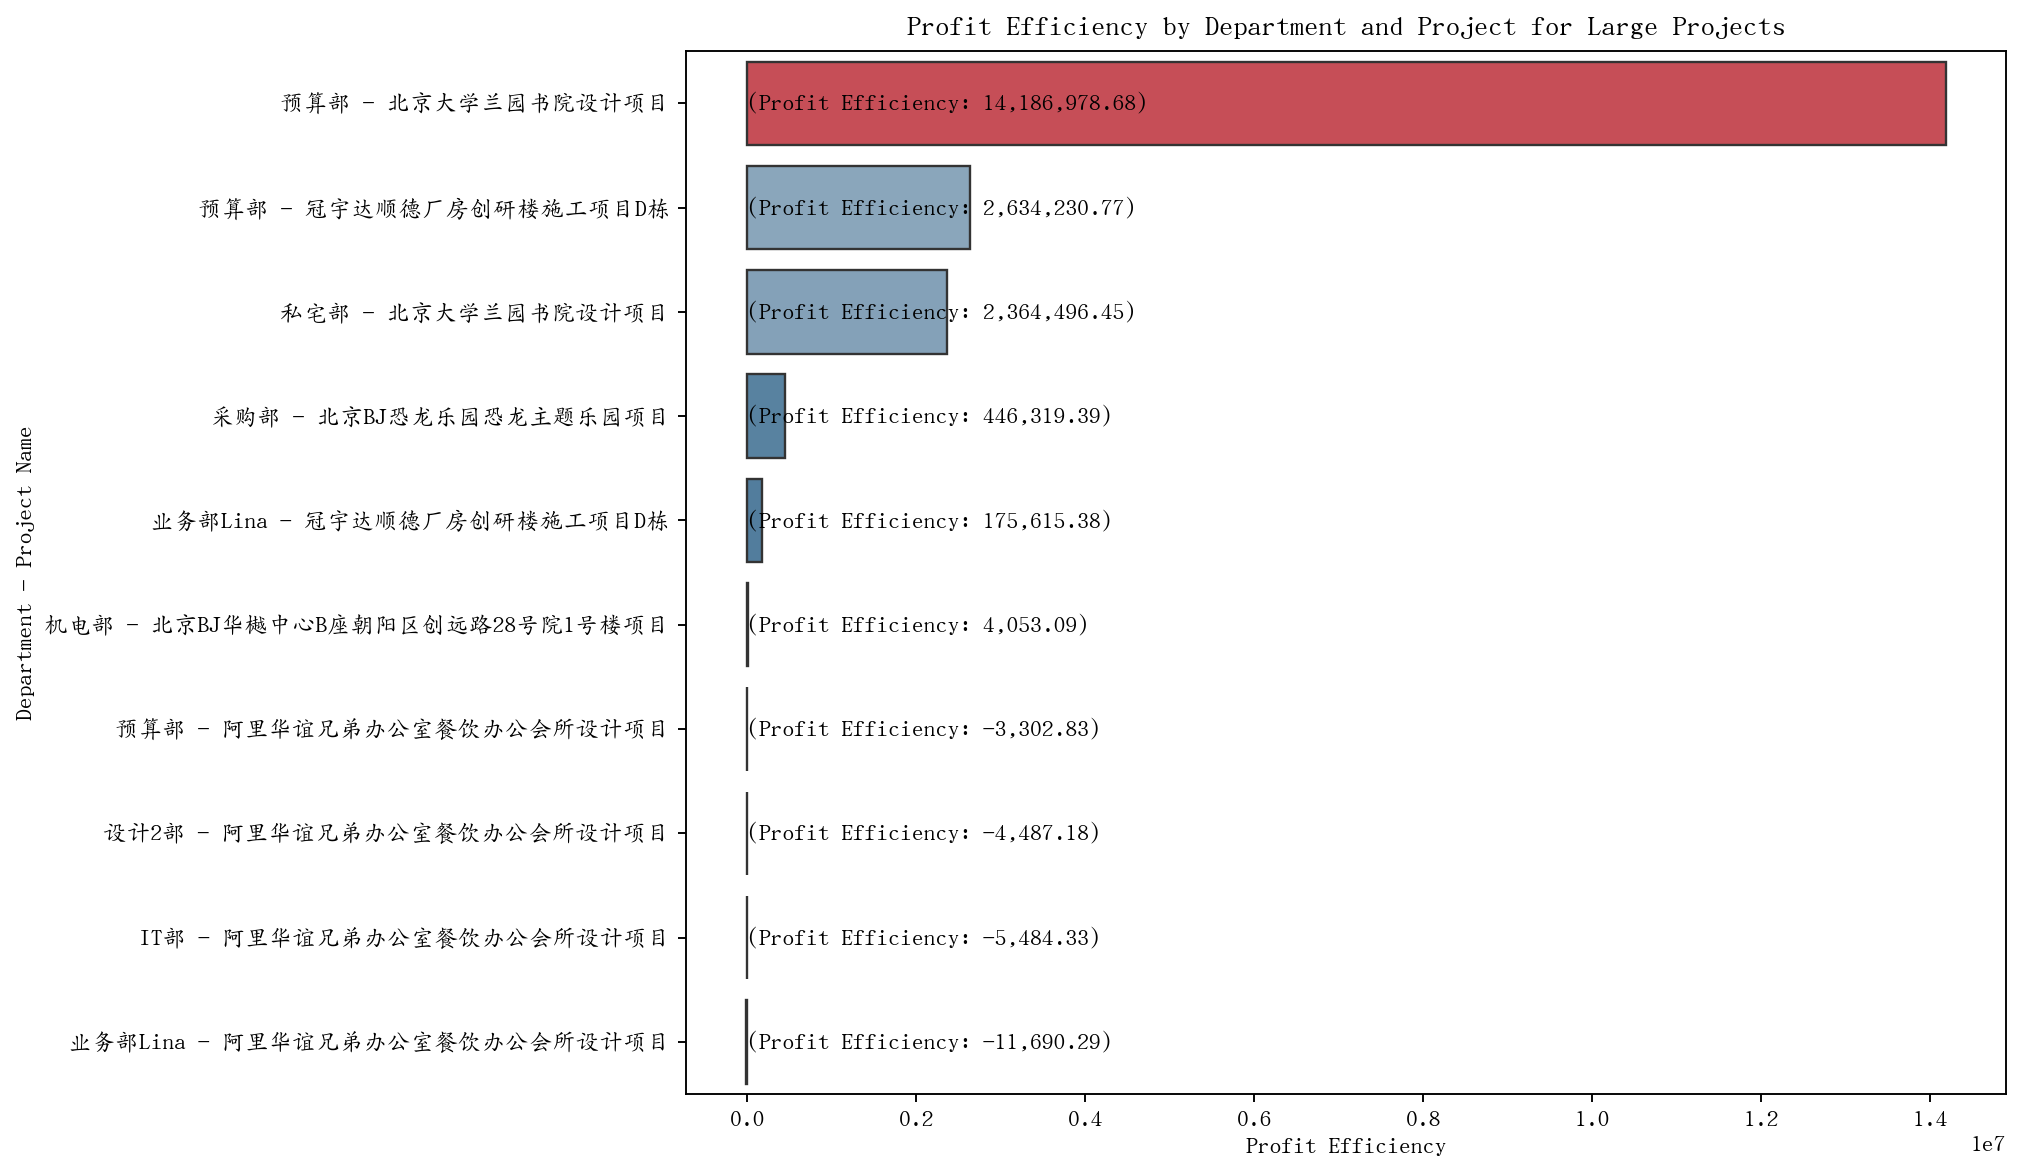

In [65]:
# Create a combined '部门_项目名称' column
sumed_df['部门_项目名称'] = sumed_df['部门'] + ' - ' + sumed_df['项目名称']

for size in sumed_df['Project_Size'].unique():
    subset = sumed_df[sumed_df['Project_Size'] == size]  # Filter data for the current project size

    # Group by project name, calculating both the median profit efficiency and winsorized efficiency
    subset = subset.groupby('部门_项目名称').agg({
        'winsorized_logged_rescaled_profit_efficiency': 'median',
        'profit_efficiency': 'median'  # Calculate the median for profit efficiency as well
    }).reset_index()

    num_rows = len(subset['部门_项目名称'].unique())  # Number of unique projects

    # If the number of rows exceeds 20, show only the top 5 and bottom 5 by profit efficiency
    if num_rows > 20:
        top_bottom_n = 5
        # Sort by profit efficiency and select top and bottom 5 projects
        top_bottom_subset = pd.concat([subset.nlargest(top_bottom_n, 'profit_efficiency'),
                                       subset.nsmallest(top_bottom_n, 'profit_efficiency')])
        subset = top_bottom_subset  # Use only the top 5 and bottom 5

    # Sort subset by profit_efficiency in descending order for better display
    subset = subset.sort_values('profit_efficiency', ascending=False)

    # Determine figure size dynamically based on number of rows
    num_rows = len(subset['部门_项目名称'].unique())  # Update number of rows after filtering
    plt.figure(figsize=(12, max(4, num_rows * 0.7)), dpi=170)  # Adjust height based on number of rows

    # Use seaborn's built-in RdYlGn color palette (red for negative, green for positive)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    # Use profit_efficiency to color the bars (coolwarm palette, warm for high, cool for low)
    norm = plt.Normalize(subset['profit_efficiency'].min(), subset['profit_efficiency'].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a horizontal bar chart and color by profit_efficiency
    bar_colors = sm.to_rgba(subset['profit_efficiency'])
    # Create a horizontal bar chart with a color gradient for winsorized efficiency
    sns.barplot(
        x='profit_efficiency', 
        y='部门_项目名称', 
        data=subset, 
        palette=bar_colors,  # Use a gradient from cool (low) to warm (high)
        edgecolor=".2"
    )

    # Add value labels to the bars for profit_efficiency only
    for i, profit_value in enumerate(subset['profit_efficiency']):
        plt.text(0, i, f'(Profit Efficiency: {profit_value:,.2f})', va='center', ha='left', color='black')  # Add profit_efficiency label

    # Adjust the x-axis labels to show the original efficiency values (inverse log transformation)
    # x_ticks = plt.gca().get_xticks()
    # x_labels = np.expm1(x_ticks) + min_eff  # Apply inverse of log1p to get original efficiency values
    # plt.gca().set_xticklabels([f'{x:,.2f}' for x in x_labels])

    # Add title and labels
    plt.title(f'Profit Efficiency by Department and Project for {size} Projects')
    plt.xlabel('Profit Efficiency')
    plt.ylabel('Department - Project Name')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.savefig(f'Profit Efficiency by Department and Project for {size}.png', dpi=300, bbox_inches='tight')   
    # Show plot
    plt.show()

**Future Plans:**

**Visualize a geographical distribution by provinces**

Use NLP to evaluate if a work hour outlier is indeed outlier or not. Which means to ensure the work hour make sense and within the rational range.

Not now, but in the future potentially: Use Machine Learning technique to fill in missing cost and revenue

**Generate Report!!**

In [66]:
# Create a PDF object
pdf = FPDF()

image_dir = os.getcwd()

# Reorder the png
selected_images = [
    'Profit Efficiency by Project.png',
    'Profit Efficiency by Department.png',
    'Profit Efficiency by Department and Project.png',
    'Project Classification.png',
    'Number of Projects by 谈判状态.png',
    'Average Profit by 谈判状态.png',
    'Profit Efficiency by Project for Large Projects',
    'Profit Efficiency by Project for Medium Projects',
    'Profit Efficiency by Project for Small Projects',
    'Profit Efficiency by Department for Large Projects.png',
    'Profit Efficiency by Department for Medium Projects.png',
    'Profit Efficiency by Department for Small Projects.png',
    'Profit Efficiency by Department and Project for Large.png',
    'Profit Efficiency by Department and Project for Medium.png',
    'Profit Efficiency by Department and Project for Small.png',
    'Boxplot of Hours by Department.png',
    'Labor Efficiency by All Department.png',
    'Labor Efficiency by Department - Below Benchmark (100).png'
]

# Check if report.pdf already exists and delete it
output_pdf_path = 'report.pdf'
if os.path.exists(output_pdf_path):
    os.remove(output_pdf_path)
    print(f'{output_pdf_path} removed.')

# Add each selected image to the PDF
for image_file in selected_images:
    print('current: ', image_file)
    image_path = os.path.join(image_dir, image_file)
    if os.path.exists(image_path):  # Check if the file exists
        pdf.add_page()
        print("adding page")
        pdf.image(image_path, x=10, y=10, w=180)  # Adjust x, y, and w for your layout
        print('adjusting layout')
    
# Save the PDF to a file
output_pdf_path = 'report.pdf'
pdf.output(output_pdf_path)
print(f"PDF saved to {output_pdf_path}")

print('--------Finished running---------')

report.pdf removed.
current:  Profit Efficiency by Project.png
adding page


KeyboardInterrupt: 

In [ ]:
# Create a PDF object
pdf = FPDF()

image_dir = os.getcwd()

# Reorder the png
selected_images = [
    'Profit Efficiency by Project.png',
    'Profit Efficiency by Department.png',
    'Profit Efficiency by Department and Project.png',
    'Project Classification.png',
    'Number of Projects by 谈判状态.png',
    'Average Profit by 谈判状态.png',
    'Profit Efficiency by Project for Large Projects',
    'Profit Efficiency by Project for Medium Projects',
    'Profit Efficiency by Project for Small Projects',
    'Profit Efficiency by Department for Large Projects.png',
    'Profit Efficiency by Department for Medium Projects.png',
    'Profit Efficiency by Department for Small Projects.png',
    'Profit Efficiency by Department and Project for Large.png',
    'Profit Efficiency by Department and Project for Medium.png',
    'Profit Efficiency by Department and Project for Small.png',
    'Boxplot of Hours by Department.png',
    'Labor Efficiency by All Department.png',
    'Labor Efficiency by Department - Below Benchmark (100).png'
]

# Check if report.pdf already exists and delete it
output_pdf_path = 'report_with_two_graphs_per_page.pdf'
if os.path.exists(output_pdf_path):
    os.remove(output_pdf_path)
    print(f'{output_pdf_path} removed.')

# Iterate through the images in pairs (2 per page)
for i in range(0, len(selected_images), 2):
    pdf.add_page()
    
    # Add the first image of the pair
    image_file_1 = selected_images[i]
    image_path_1 = os.path.join(image_dir, image_file_1)
    if os.path.exists(image_path_1):
        pdf.image(image_path_1, x=10, y=10, w=180)  # Adjust position and size of the image
        
    # Add the second image of the pair (if it exists)
    if i + 1 < len(selected_images):
        image_file_2 = selected_images[i + 1]
        image_path_2 = os.path.join(image_dir, image_file_2)
        if os.path.exists(image_path_2):
            pdf.image(image_path_2, x=10, y=160, w=180)  # Adjust position for the second image
    
    
# Save the PDF to a file
output_pdf_path = 'report_with_two_graphs_per_page.pdf'
pdf.output(output_pdf_path)
print(f"PDF saved to {output_pdf_path}")

print('--------Finished running---------')

After it finish running, download pdf report from [here](https://data101.datahub.berkeley.edu/user/shuran1030/files/report.pdf?_xsrf=MnwxOjB8MTA6MTcyOTgzMDEyM3w1Ol94c3JmfDEzMjpOakV4TXpnelpEazVObVl4TkROaE9UazBZMlJoTm1ZeU5EazRPR0l3WWpVNk4yVXdNVEJtT0dNNE1UYzJPRE5pTWpKbU9URmpNRGN6T0RJellqWmtNVFF4TXpFNFpEazFNbU5tWkRFME1UQmtNRFprWlRVeU1qSmtZVGs1Wmpsa05RPT18ODJlYjhlY2ZkNDkzZDg4NjRmM2M2NWE2ODA0M2FjMzdlMDRmZTg1MDNlOGI4ZTM4MzE1MTM5ZmEzYWU5MTlhOQ)

In [ ]:
output_dir = os.getcwd()  # This will be the current directory of Jupyter notebook
zip_filename = 'report.zip'
pdf_file = 'report.pdf'  # Assuming report.pdf is in the same directory

# List of CSV files we want to include in the zip (specify the exact file names)
csv_files = ['overwork_log.csv', 'labor_efficiency_below_benchmark.csv', 'all_nlp_results.csv', 'merged.csv', 'calculated.csv'] 

# Create a zip file and add all .png and specified .csv files from the current directory
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add all .png files
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file.endswith('.png'):
                zipf.write(os.path.join(root, file), arcname=file)

    # Add specified .csv files
    for csv_file in csv_files:
        csv_path = os.path.join(output_dir, csv_file)
        if os.path.exists(csv_path):  # Check if the CSV file exists before adding
            zipf.write(csv_path, arcname=csv_file)
    # Add the PDF report if it exists
    pdf_path = os.path.join(output_dir, pdf_file)
    if os.path.exists(pdf_path):  # Check if the PDF file exists before adding
        zipf.write(pdf_path, arcname=pdf_file)

print(f"ZIP file generated at {zip_filename}")

After it finish running, download report.zip from [here](https://data101.datahub.berkeley.edu/user/shuran1030/files/report.zip?_xsrf=MnwxOjB8MTA6MTcyOTgyMTczOXw1Ol94c3JmfDEzMjpOakV4TXpnelpEazVObVl4TkROaE9UazBZMlJoTm1ZeU5EazRPR0l3WWpVNk56QXhPVGt6TkRSa09HVmxZbVJpWlRVek1HVTNNbUppT1dFMVpERTJabUkyWlRKaFpqSTJaRFUxWkRRNFlqQTFOVFl5TkRsa1ptWXdPR1V3TURNNE5BPT18NjBjNmYyZWM0ZTg3ZGUxY2Q5YWZhMGYzMjVhZWU4Y2YyNDE5NDUxZjg5NDYyMzFjNTk3ODlhOGIzY2Q4ZmZlNQ)